<hr style="border:2px solid Teal"> </hr>

# Speech Coding Strategies for Cochlear Implants

<hr style="border:2px solid Teal"> </hr>

In [306]:
using PyPlot
using WAV
using DSP
using FFTW

In [307]:
include("src/utils.jl")
include("src/plotting.jl");

In [308]:
path = "./data/"
file = "emodb_neutral.wav"
file = "emodb_happy.wav"
wav_file = wavread(string(path,file));
audio_orig = wav_file[1][:,1]; # just one channel
Fs = wav_file[2]; # sampling rate

# First 3.5 ms
# time_end = convert(Int, 3.5 * Fs)
time_end = length(audio_orig)
time = (0:time_end-1)/Fs
audio_orig = audio_orig[1:time_end];

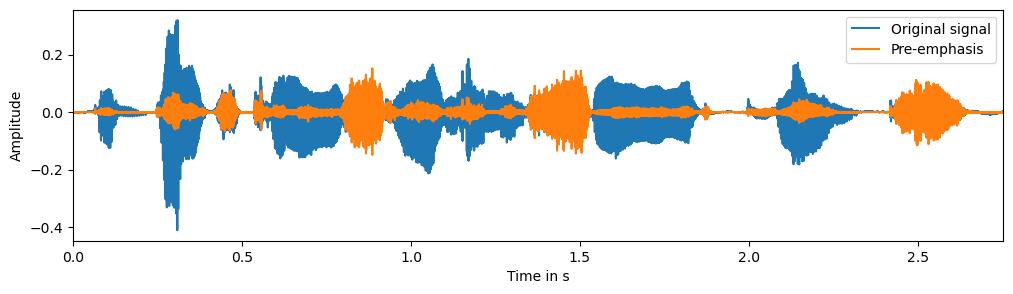

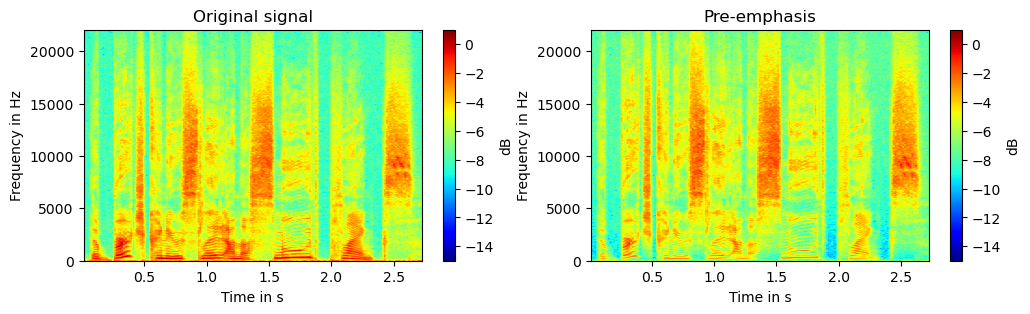

In [309]:
# perform pre-emphasis on audio signal
audio = pre_emph(audio_orig)

#----------------------------------------------------------------------
# Plotting

figure(figsize=(12,3))
plot_audio(time,audio_orig)
plot_audio(time,audio)
legend(["Original signal", "Pre-emphasis"])

figure(figsize=(12,3))
subplot(1,2,1)
plot_spectrogram(audio_orig, Fs)
title("Original signal")
subplot(1,2,2)
plot_spectrogram(audio, Fs)
title("Pre-emphasis");
#----------------------------------------------------------------------

<hr style="border:2px solid black"> </hr>

### House/3M Single Channel CI [fretz+1985]

![title](img/House_3M_Single_Channel_CI.png)


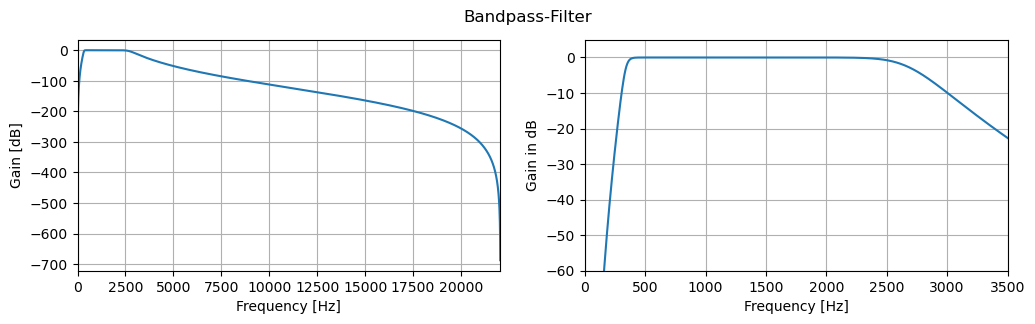

In [310]:
prototype = Butterworth(8);
responsetype = Bandpass(340,2700; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);

ω = 0:0.001:pi 
H = freqz(cochlear_filter, ω)

figure(figsize=(12,3))

suptitle("Bandpass-Filter")
subplot(1,2,1)
plot(Fs/2*ω/pi, 20*log10.(abs.(H)))
xlabel("Frequency [Hz]")
ylabel("Gain [dB]")
xlim([0,last(Fs/2*ω/pi)])
grid()

subplot(1,2,2)
plot(Fs/2*ω/pi, 20*log10.(abs.(H)))
xlabel("Frequency [Hz]")
ylabel("Gain in dB")
xlim([0,3500])
ylim([-60,5])
grid()

# Filtering the input signal
audio_filt = filt(cochlear_filter, audio);

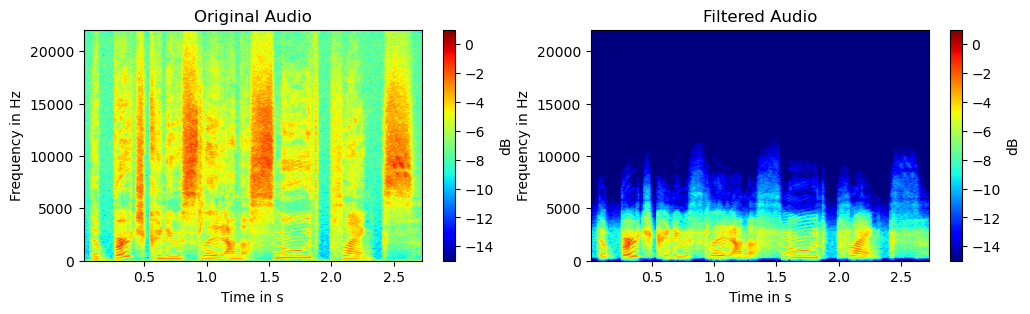

In [311]:
figure(figsize=(12,3))
subplot(1,2,1)
plot_spectrogram(audio, Fs)
title("Original Audio")

subplot(1,2,2)
plot_spectrogram(audio_filt, Fs)
title("Filtered Audio");

In [312]:
f = 16e3
if f > Fs/2
    f = Fs/8
end
    
f_carr = sin.(2*pi*f.*time)
f_electrode = f_carr .* audio_filt;

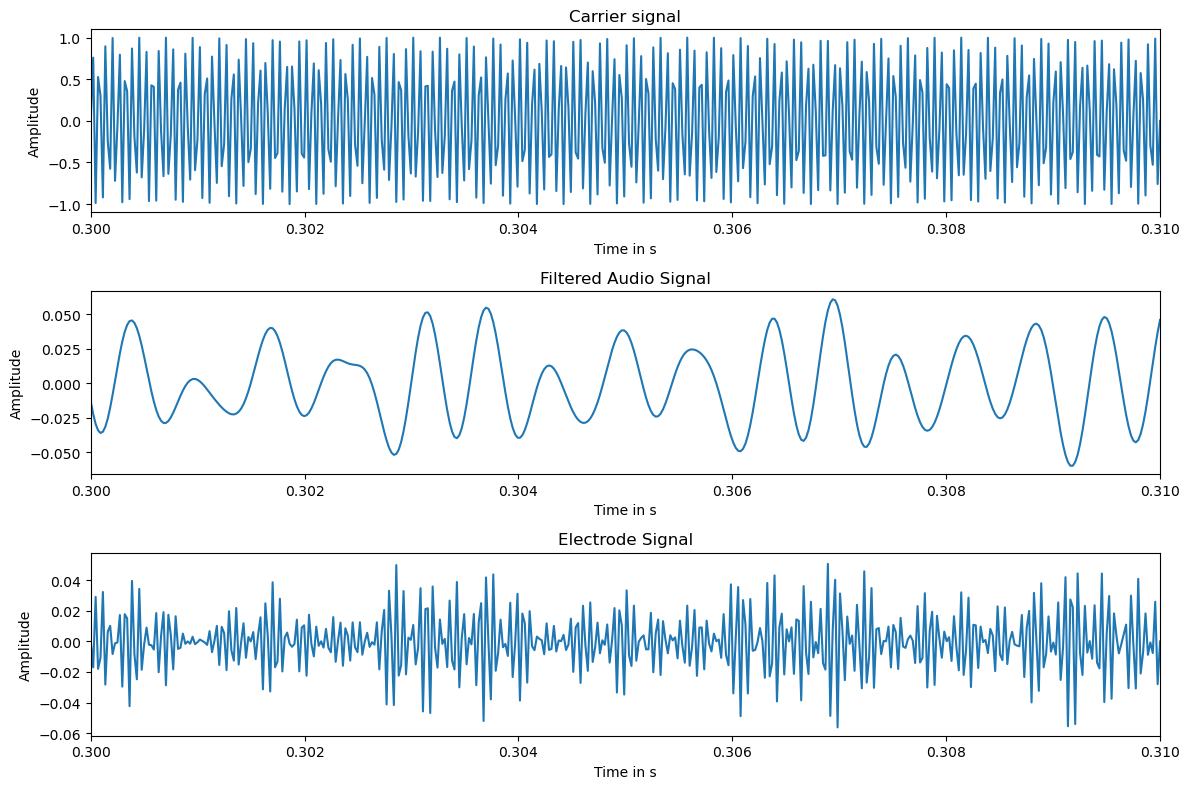

In [313]:
figure(figsize=(12,8))

subplot(3,1,1)
plot_audio(time,f_carr)
xlim([0.3,0.31])
title("Carrier signal")

subplot(3,1,2)
plot_audio(time,audio_filt)
xlim([0.3,0.31])
title("Filtered Audio Signal")

subplot(3,1,3)
plot_audio(time, f_electrode)
xlim([0.3,0.31])
title("Electrode Signal")

tight_layout()

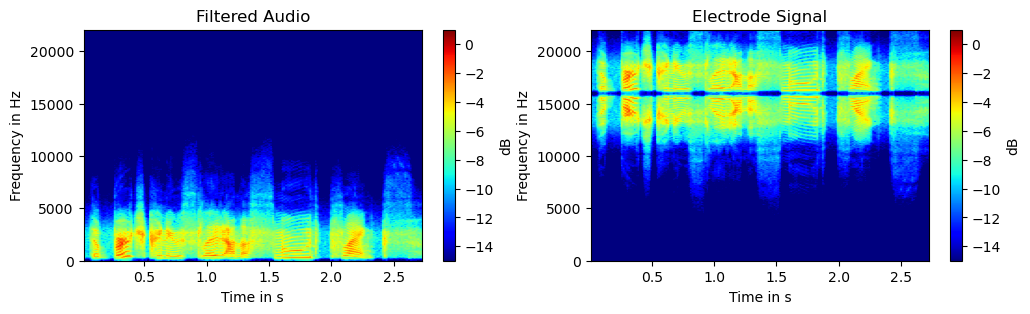

In [314]:
figure(figsize=(12,3))
subplot(1,2,1)
plot_spectrogram(audio_filt, Fs)
title("Filtered Audio")

subplot(1,2,2)
plot_spectrogram(f_electrode, Fs)
title("Electrode Signal");

<hr style="border:2px solid black"> </hr>

### Multi-channel Analog CI

![title](img/Multi_channel_Analog_CI.png)


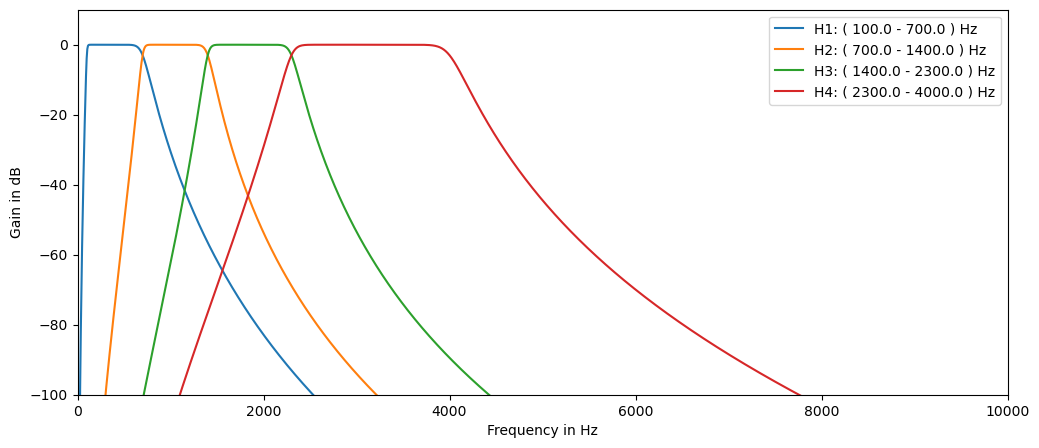

In [315]:
freq_passband = [[0.1,0.7]   [0.7,1.4]    [1.4,2.3]   [2.3, 4]]*1e3

filter_output = zeros(4,length(audio))
ω = 0:0.001:pi 

legend_str = Array{Union{Nothing, String}}(nothing, 4)

figure(figsize=(12,5))

for i in 1:4
    responsetype = Bandpass(freq_passband[1,i], freq_passband[2,i]; fs=Fs);
    prototype = Butterworth(8);
    cochlear_filter = digitalfilter(responsetype, prototype);
    
    H = freqz(cochlear_filter, ω)
    plot(Fs/2*ω/pi, 20*log10.(abs.(H)))
    xlim([0,10e3])
    ylim([-100,10])
    xlabel("Frequency in Hz")
    ylabel("Gain in dB")
    filter_output[i,:] = filt(cochlear_filter, audio);
    legend_str[i] = string("H",i,": ","( ",freq_passband[1,i]," - ",freq_passband[2,i]," ) Hz")
end
legend(legend_str);

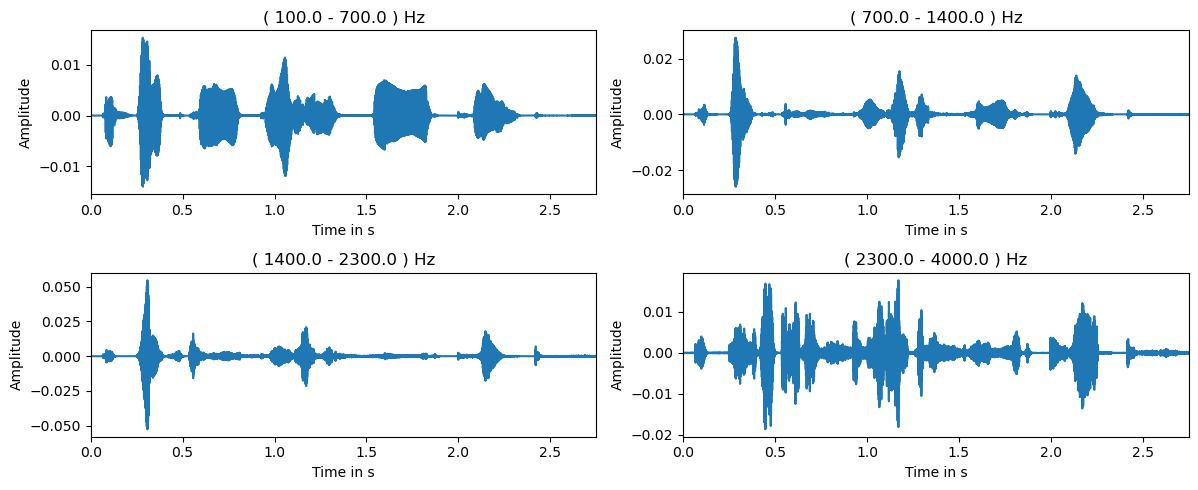

In [316]:
figure(figsize=(12,5))

for i in 1:4
    subplot(2,2,i)
    plot_audio(time,filter_output[i,:])
    title(string("( ",freq_passband[1,i]," - ",freq_passband[2,i]," ) Hz"))
end
tight_layout()

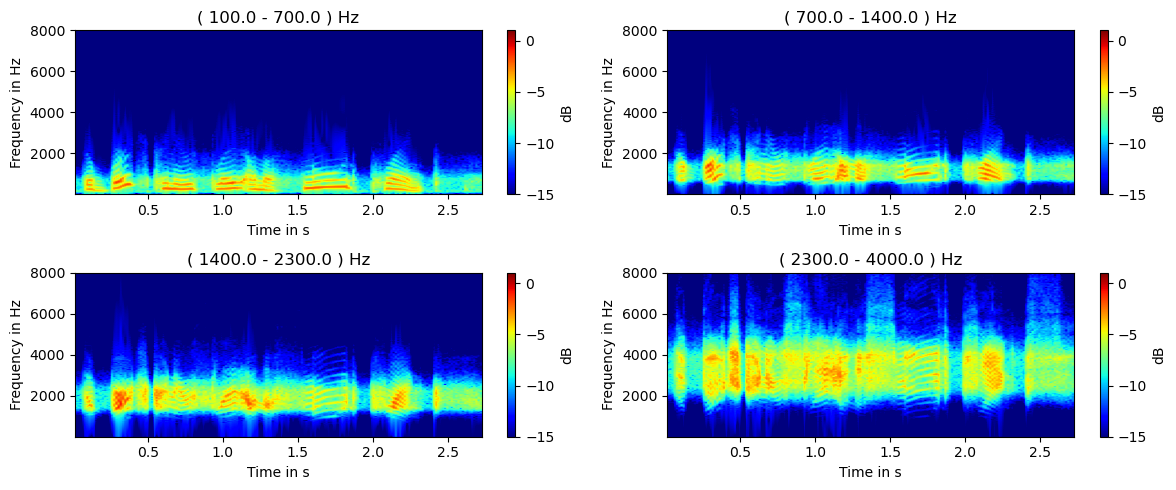

In [317]:
figure(figsize=(12,5))

for i in 1:4
    subplot(2,2,i)
    plot_spectrogram(filter_output[i,:], Fs)
    title(string("( ",freq_passband[1,i]," - ",freq_passband[2,i]," ) Hz"))
    ylim([1, 8e3])
end
tight_layout()

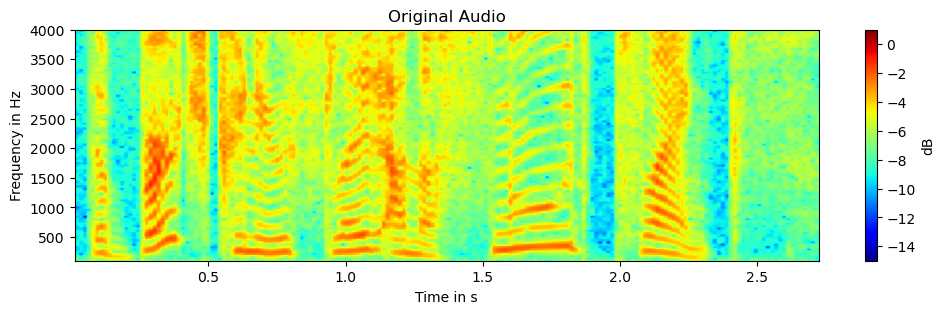

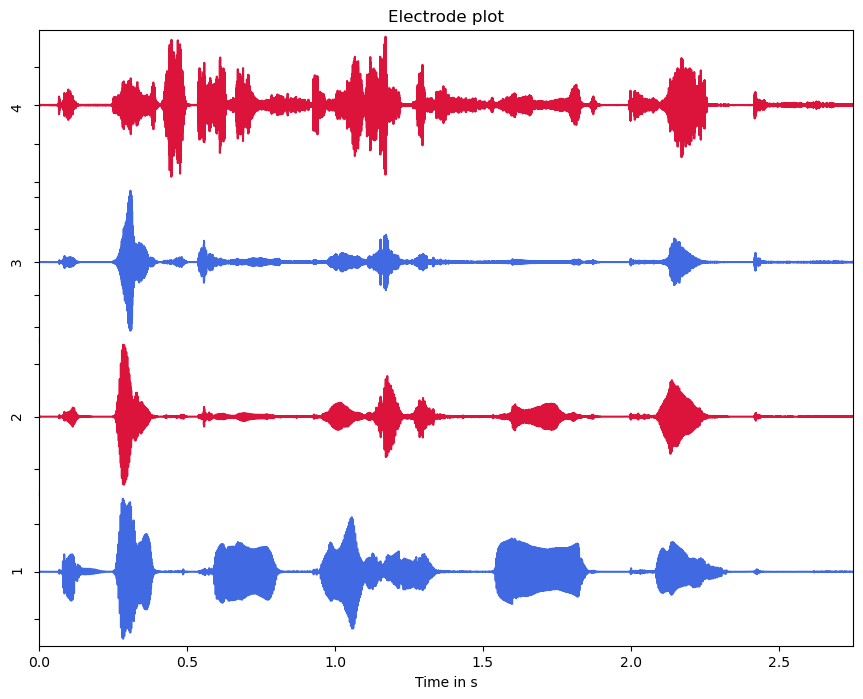

In [318]:
figure(figsize=(12,3))
plot_spectrogram(audio, Fs)
ylim([100,4000])
title("Original Audio")

plot_electrode(4,time,filter_output)

<hr style="border:2px solid black"> </hr>

### Feature Extraction Strategy F0-F2

![title](img/feature_f0_f2.png)

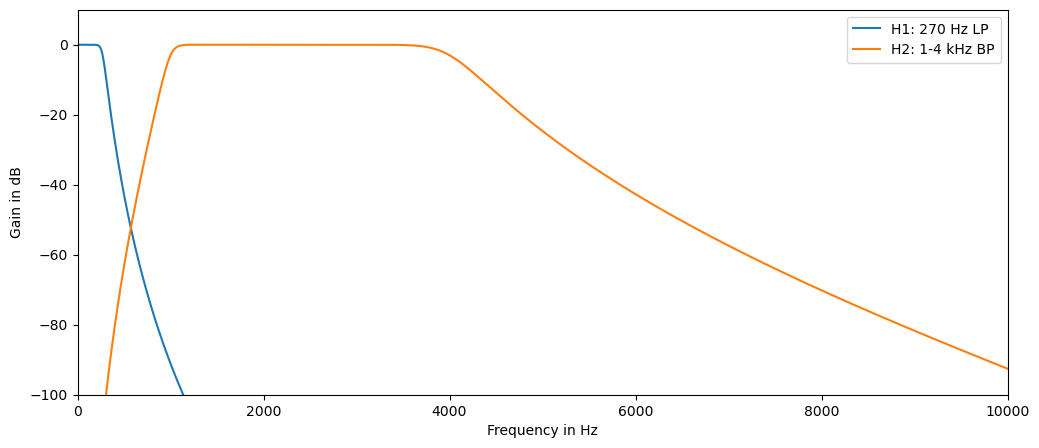

In [319]:
filter_output = zeros(2,length(audio))
ω = 0:0.001:pi 

prototype = Butterworth(8);

responsetype = Lowpass(270; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_low = freqz(cochlear_filter, ω)
filter_output[1,:] = filt(cochlear_filter, audio);

responsetype = Bandpass(1e3, 4e3; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_bp = freqz(cochlear_filter, ω)
filter_output[2,:] = filt(cochlear_filter, audio);

figure(figsize=(12,5))
plot(Fs/2*ω/pi, 20*log10.(abs.(H_low)))
plot(Fs/2*ω/pi, 20*log10.(abs.(H_bp)))
xlim([0,10e3])
ylim([-100,10])
xlabel("Frequency in Hz")
ylabel("Gain in dB")
legend(("H1: 270 Hz LP","H2: 1-4 kHz BP"));

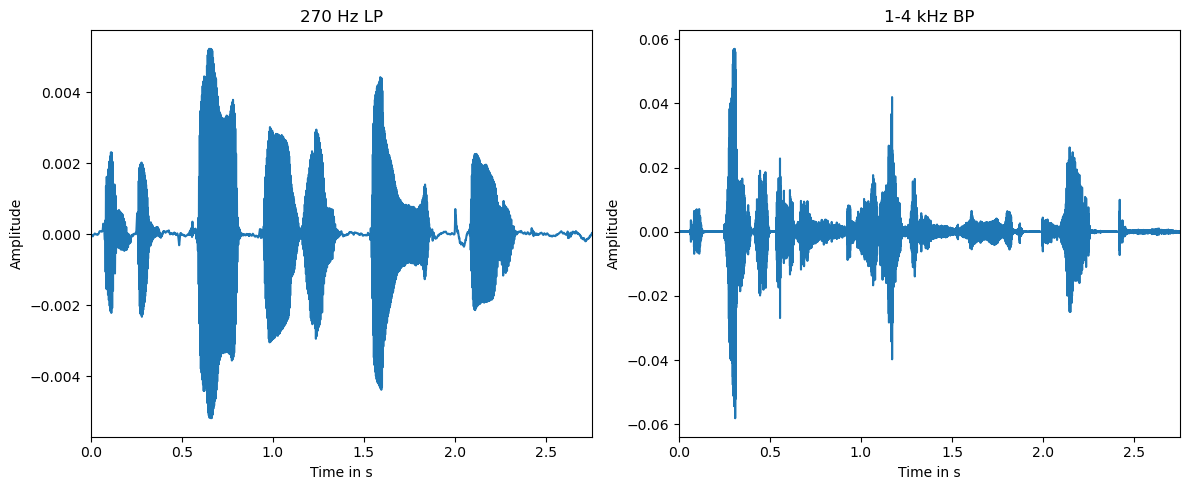

In [320]:
figure(figsize=(12,5))
title_str = ["270 Hz LP", "1-4 kHz BP"]

for i in 1:2
    subplot(1,2,i)
    plot_audio(time,filter_output[i,:])
    title(title_str[i])
end

tight_layout()

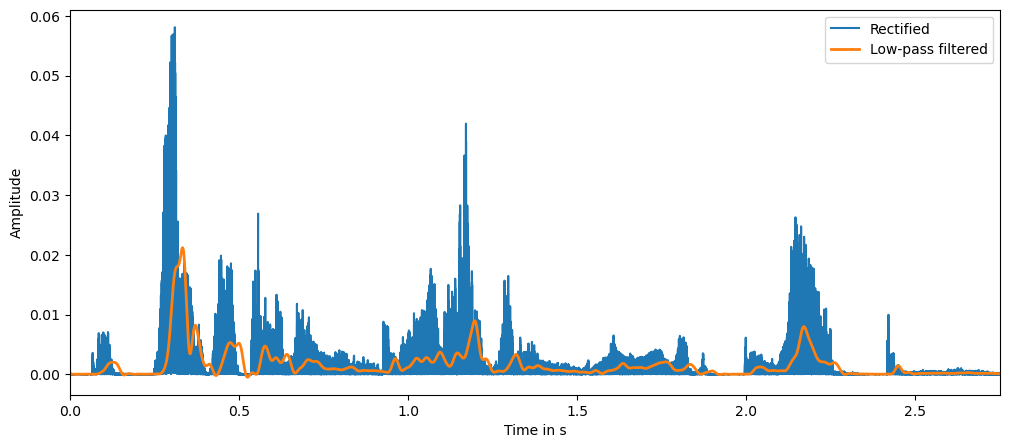

In [321]:
prototype = Butterworth(8);
responsetype = Lowpass(35; fs=Fs);
lp_filter = digitalfilter(responsetype, prototype);
rect_audio = abs.(filter_output[2,:])
rect_low = filt(lp_filter, rect_audio);

figure(figsize=(12,5))
plot_audio(time,rect_audio)
plot(time,rect_low,lw=2)
legend(["Rectified", "Low-pass filtered"]);

Partition the speech signal into smaller, overlapping frames.

In [322]:
signal_frames_F0 = generate_frames(filter_output[1,:],Fs);
signal_frames_F2 = generate_frames(filter_output[2,:],Fs);
frame_length = size(signal_frames_F0)[2]
number_frames = size(signal_frames_F0)[1]
time_frames = collect( range(0,last(time),length=number_frames) )

F0_ZC = zeros((number_frames,1))
F2_ZC = zeros((number_frames,1))

for (idx,i) in enumerate(1:number_frames)
    F0_ZC[idx] = freq_est_ZC(signal_frames_F0[i,:],Fs)
    F2_ZC[idx] = freq_est_ZC(signal_frames_F2[i,:],Fs)
end

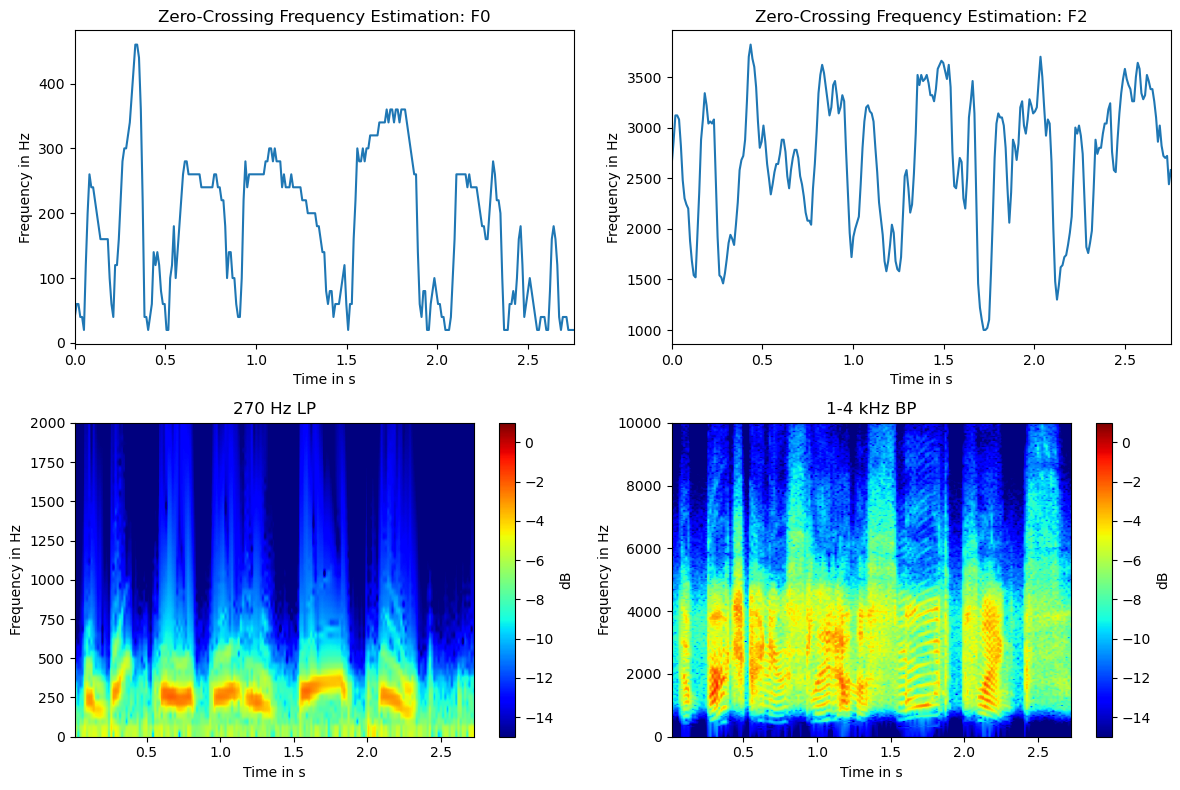

In [323]:
##----------------------------------------------------------------------##
# Plots
##----------------------------------------------------------------------##

figure(figsize=(12,8))
subplot(2,2,1)
plot_audio(time_frames,F0_ZC)
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation: F0")
subplot(2,2,2)
plot_audio(time_frames,F2_ZC)
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation: F2")

subplot(2,2,3)
plot_spectrogram(filter_output[1,:], Fs)
ylim([0,2000])
title(title_str[1])
subplot(2,2,4)
plot_spectrogram(filter_output[2,:], Fs)
ylim([0,10000])
title(title_str[2])

tight_layout()

In [324]:
N_electrodes = 22

(electrode_signal, electrodes, pulses, freq_spacing) = pulse_generation(Fs,F0_ZC,F2_ZC,rect_low,N_electrodes);

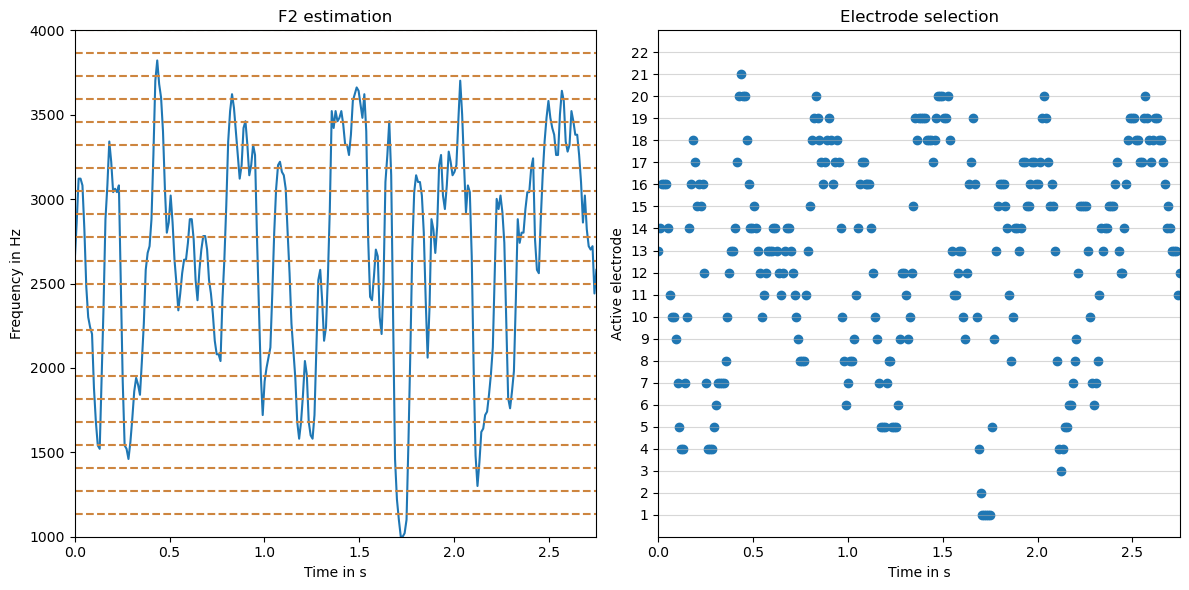

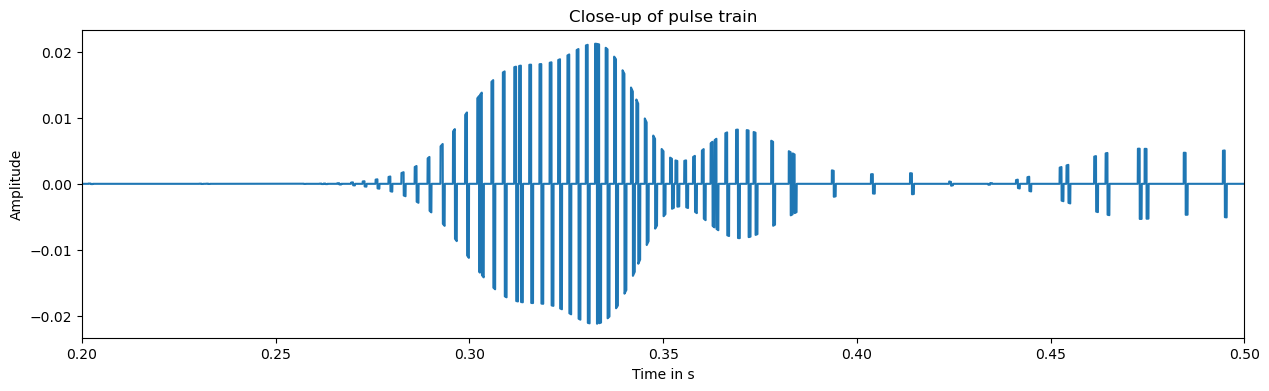

In [325]:
##----------------------------------------------------------------------##
# Plots
##----------------------------------------------------------------------##

figure(figsize=(12,6))

subplot(1,2,1)
plot_audio(time_frames,F2_ZC)
[ plt.axhline(y=hline,color="peru",linestyle="--") for hline in freq_spacing]
ylim([1000,4000])
ylabel("Frequency in Hz")
title("F2 estimation")

subplot(1,2,2)
scatter(time_frames,electrodes)
xlabel("Time in s")
ylabel("Active electrode")
xlim([0,last(time)])
ylim([0,N_electrodes+1])
yticks(collect(1:N_electrodes))
grid("minor",axis="y",alpha=0.5)
title("Electrode selection")

tight_layout()

figure(figsize=(15,4))
plot_audio(time,pulses)
title("Close-up of pulse train")
xlim([0.2,0.5]);

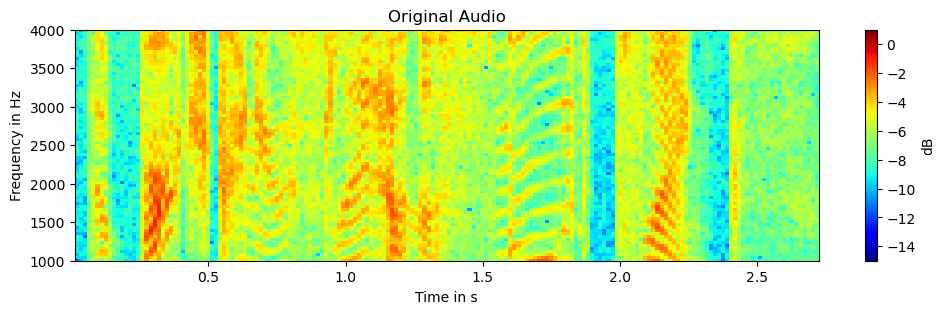

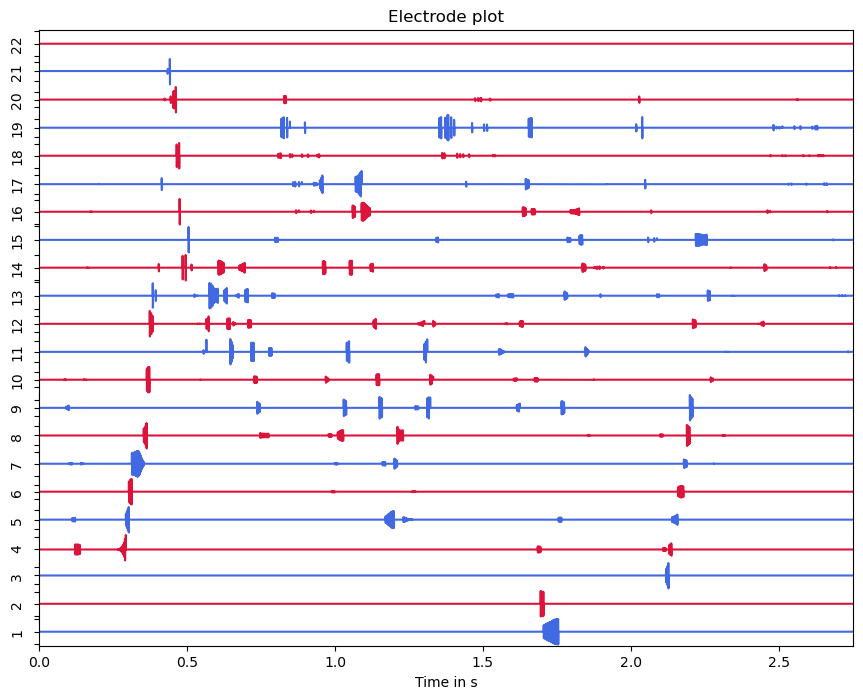

In [326]:
figure(figsize=(12,3))
plot_spectrogram(audio, Fs)
ylim([1000,4000])
title("Original Audio")

#------------------------------------------------------------------------
# Electrode plot

plot_electrode(N_electrodes,time,electrode_signal)

<hr style="border:2px solid black"> </hr>

### Feature Extraction Strategy F0-F1-F2

![title](img/feature_f0_f1_f2.png)

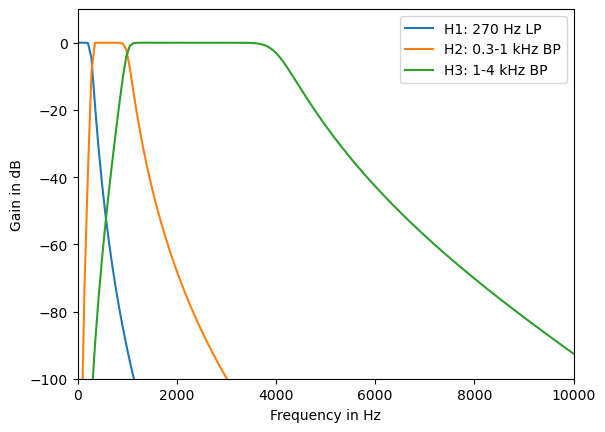

In [327]:
filter_output = zeros(3,length(audio))
ω = 0:0.01:pi 

prototype = Butterworth(8);

responsetype = Lowpass(270; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_low = freqz(cochlear_filter, ω)
filter_output[1,:] = filt(cochlear_filter, audio);

responsetype = Bandpass(0.3e3, 1e3; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_bp_low = freqz(cochlear_filter, ω)
filter_output[2,:] = filt(cochlear_filter, audio);

responsetype = Bandpass(1e3, 4e3; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_bp_up = freqz(cochlear_filter, ω)
filter_output[3,:] = filt(cochlear_filter, audio);

plot(Fs/2*ω/pi, 20*log10.(abs.(H_low)))
plot(Fs/2*ω/pi, 20*log10.(abs.(H_bp_low)))
plot(Fs/2*ω/pi, 20*log10.(abs.(H_bp_up)))
xlim([0,10e3])
ylim([-100,10])
xlabel("Frequency in Hz")
ylabel("Gain in dB")
legend(("H1: 270 Hz LP","H2: 0.3-1 kHz BP","H3: 1-4 kHz BP"));

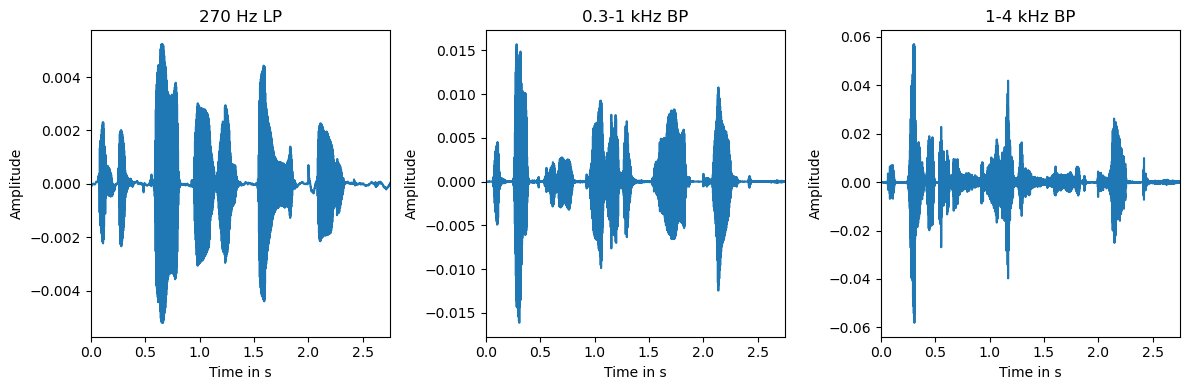

In [328]:
figure(figsize=(12,4))
title_str = ["270 Hz LP", "0.3-1 kHz BP", "1-4 kHz BP"]

for i in 1:3
    subplot(1,3,i)
    plot_audio(time,filter_output[i,:])
    title(title_str[i])
end

tight_layout()

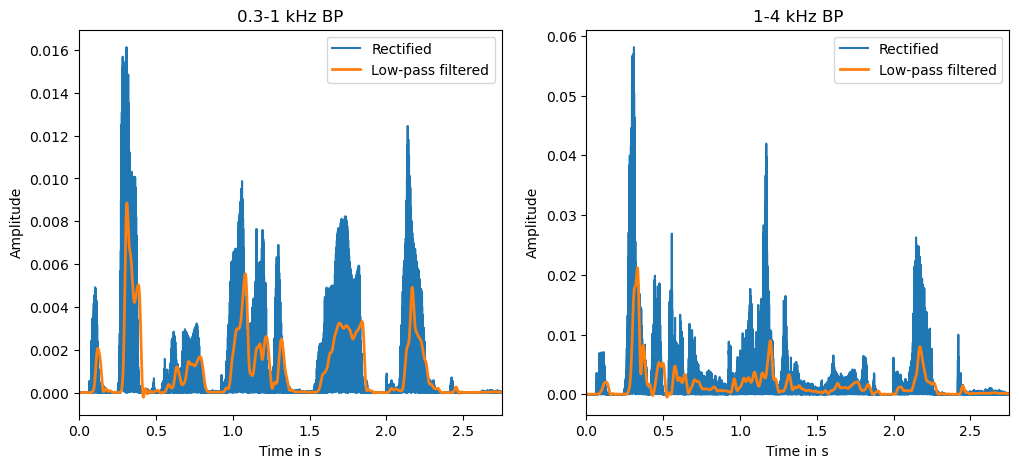

In [329]:
prototype = Butterworth(8)
responsetype = Lowpass(35; fs=Fs)
lp_filter = digitalfilter(responsetype, prototype)
rect_audio_bp_low = abs.(filter_output[2,:])
rect_audio_bp_high = abs.(filter_output[3,:])
rect_low_bp_low = filt(lp_filter, rect_audio_bp_low)
rect_low_bp_high = filt(lp_filter, rect_audio_bp_high);

figure(figsize=(12,5))
subplot(1,2,1)
plot_audio(time,rect_audio_bp_low)
plot(time,rect_low_bp_low,lw=2)
legend(["Rectified", "Low-pass filtered"])
title(title_str[2])
subplot(1,2,2)
plot_audio(time,rect_audio_bp_high)
plot(time,rect_low_bp_high,lw=2)
legend(["Rectified", "Low-pass filtered"])
title(title_str[3]);

In [330]:
signal_frames_F0 = generate_frames(filter_output[1,:],Fs);
signal_frames_F1 = generate_frames(filter_output[2,:],Fs);
signal_frames_F2 = generate_frames(filter_output[3,:],Fs);

frame_length = size(signal_frames_F0)[2]
number_frames = size(signal_frames_F0)[1]
time_frames = collect( range(0,last(time),length=number_frames) )

F0_ZC = zeros((number_frames,1))
F1_ZC = zeros((number_frames,1))
F2_ZC = zeros((number_frames,1))

for (idx,i) in enumerate(1:number_frames)
    F0_ZC[idx] = freq_est_ZC(signal_frames_F0[i,:],Fs)
    F1_ZC[idx] = freq_est_ZC(signal_frames_F1[i,:],Fs)
    F2_ZC[idx] = freq_est_ZC(signal_frames_F2[i,:],Fs)
end

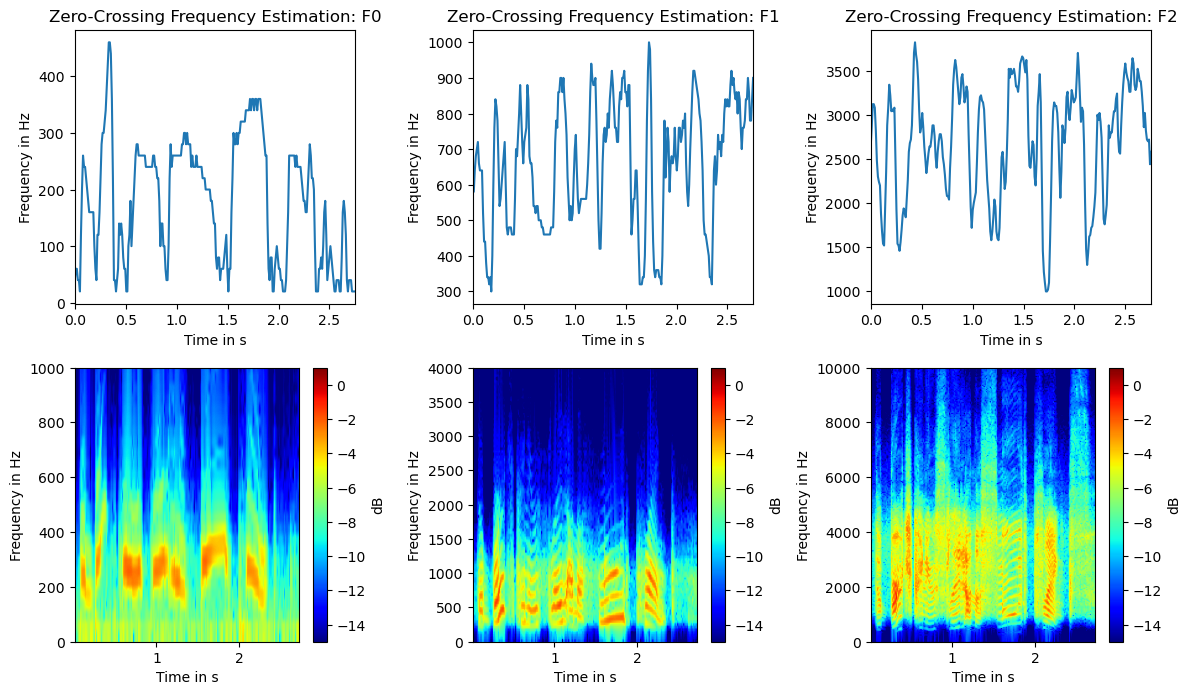

In [331]:
figure(figsize=(12,10))
subplot(3,3,1)
plot_audio(time_frames,F0_ZC)
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation: F0")
subplot(3,3,2)
plot_audio(time_frames,F1_ZC)
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation: F1")
subplot(3,3,3)
plot_audio(time_frames,F2_ZC)
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation: F2")

subplot(3,3,4)
plot_spectrogram(filter_output[1,:], Fs)
ylim([0,1000])
subplot(3,3,5)
plot_spectrogram(filter_output[2,:], Fs)
ylim([0,4000])
subplot(3,3,6)
plot_spectrogram(filter_output[3,:], Fs)
ylim([0,10000])

tight_layout()

In [332]:
N_electrodes_apical = 5
(electrode_signal_apical, electrodes_apical, pulses_apical, freq_spacing_apical) = pulse_generation(Fs,F0_ZC,F1_ZC,rect_low_bp_low,N_electrodes_apical,f_low=300,f_high=maximum(F1_ZC))
N_electrodes_basal = 15
(electrode_signal_basal, electrodes_basal, pulses_basal, freq_spacing_basal) = pulse_generation(Fs,F0_ZC,F2_ZC,rect_low_bp_high,N_electrodes_basal);

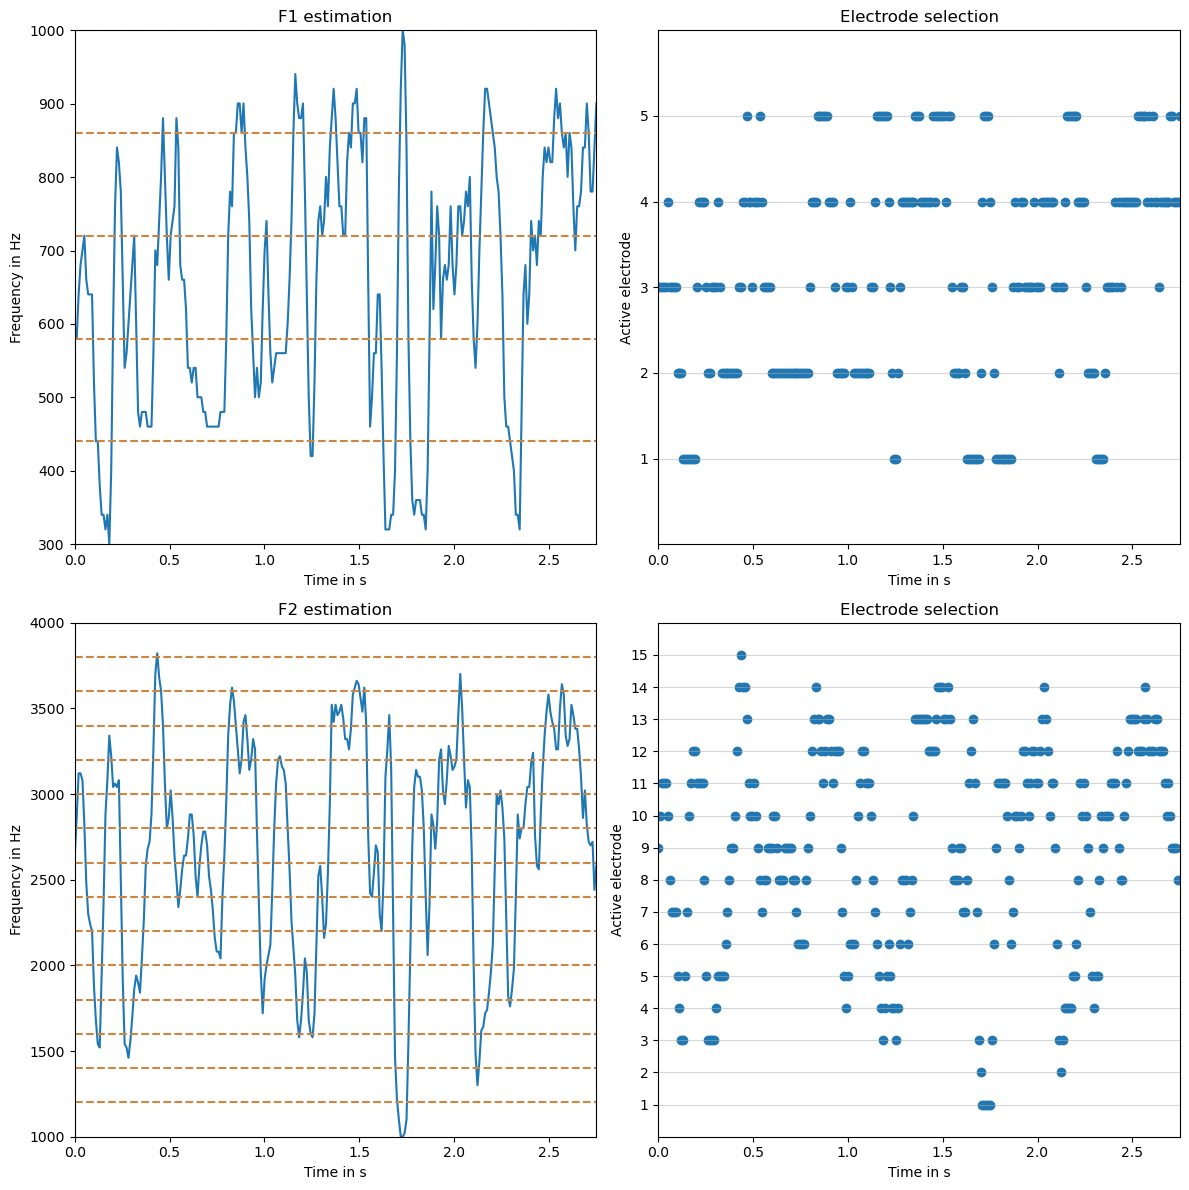

In [333]:
##----------------------------------------------------------------------##
# Plots
##----------------------------------------------------------------------##

figure(figsize=(12,12))

subplot(2,2,1)
plot_audio(time_frames,F1_ZC)
[ plt.axhline(y=hline,color="peru",linestyle="--") for hline in freq_spacing_apical]
ylim([300,1000])
ylabel("Frequency in Hz")
title("F1 estimation")

subplot(2,2,2)
scatter(time_frames,electrodes_apical)
xlabel("Time in s")
ylabel("Active electrode")
xlim([0,last(time)])
ylim([0,N_electrodes_apical+1])
yticks(collect(1:N_electrodes_apical))
grid("minor",axis="y",alpha=0.5)
title("Electrode selection")

subplot(2,2,3)
plot_audio(time_frames,F2_ZC)
[ plt.axhline(y=hline,color="peru",linestyle="--") for hline in freq_spacing_basal]
ylim([1000,4000])
ylabel("Frequency in Hz")
title("F2 estimation")

subplot(2,2,4)
scatter(time_frames,electrodes_basal)
xlabel("Time in s")
ylabel("Active electrode")
xlim([0,last(time)])
ylim([0,N_electrodes_basal+1])
yticks(collect(1:N_electrodes_basal))
grid("minor",axis="y",alpha=0.5)
title("Electrode selection")

tight_layout()

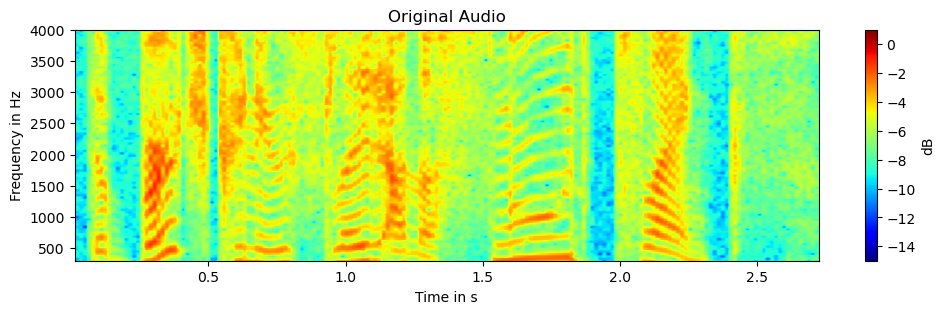

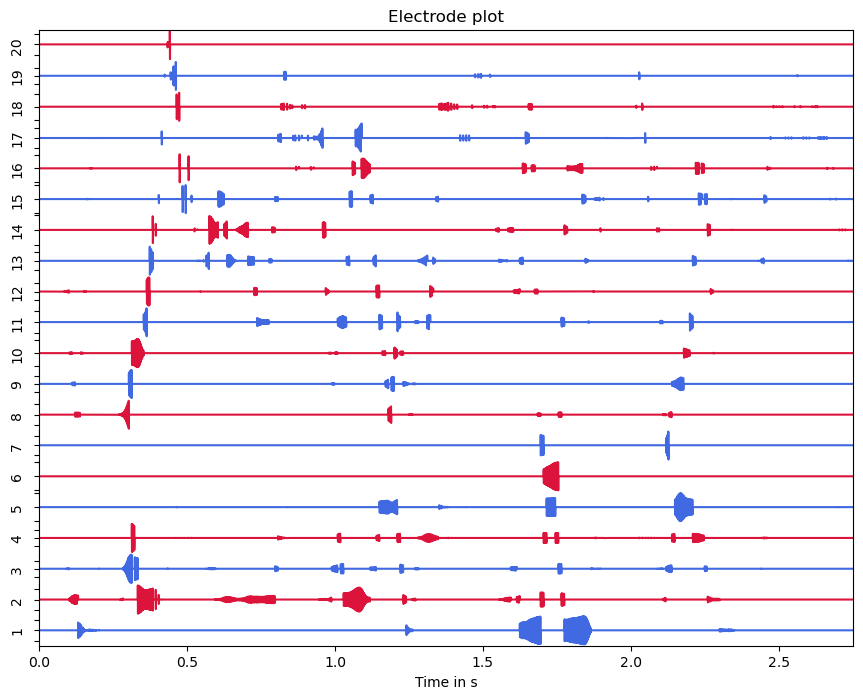

In [334]:
figure(figsize=(12,3))
plot_spectrogram(audio, Fs)
ylim([300,4000])
title("Original Audio")

electrodes_concat = [electrode_signal_apical;electrode_signal_basal]
plot_electrode(20,time,electrodes_concat)

<hr style="border:2px solid black"> </hr>

### Continuous Interleaved Sampling – CIS

![title](img/CIS.png)

In [335]:
N_channel = 6
low_freq_mel = (2595 * log10(1 + (100) / 700))  # Convert Hz to Mel
high_freq_mel = (2595 * log10(1 + (4000) / 700))  # Convert Hz to Mel
mel_points = range(low_freq_mel, high_freq_mel, length = N_channel + 1)  # Equally spaced in Mel scale
hz_points = round.( (700 .* (10 .^(mel_points ./ 2595) .- 1)) ); # Convert Mel to Hz

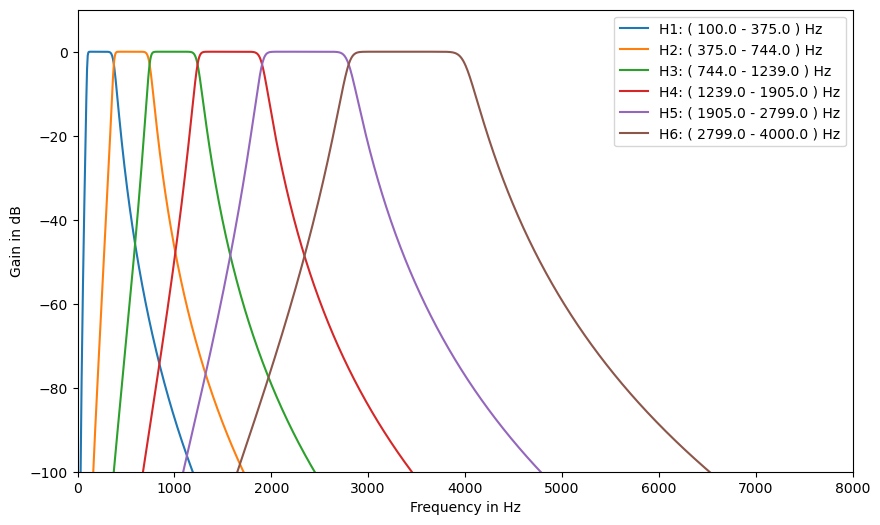

In [336]:
filter_output = zeros(N_channel,length(audio))
ω = 0:0.001:pi 

legend_str = Array{Union{Nothing, String}}(nothing, N_channel)

figure(figsize=(10,6))
for i in 1:N_channel
    responsetype = Bandpass(hz_points[i], hz_points[i+1]; fs=Fs);
    prototype = Butterworth(8);
    cochlear_filter = digitalfilter(responsetype, prototype);
    
    H = freqz(cochlear_filter, ω)
    plot(Fs/2*ω/pi, 20*log10.(abs.(H)))
    xlim([0,8e3])
    ylim([-100,10])
    xlabel("Frequency in Hz")
    ylabel("Gain in dB")
    filter_output[i,:] = filt(cochlear_filter, audio);
    legend_str[i] = string("H",i,": ","( ",hz_points[i]," - ",hz_points[i+1]," ) Hz")
end
legend(legend_str);

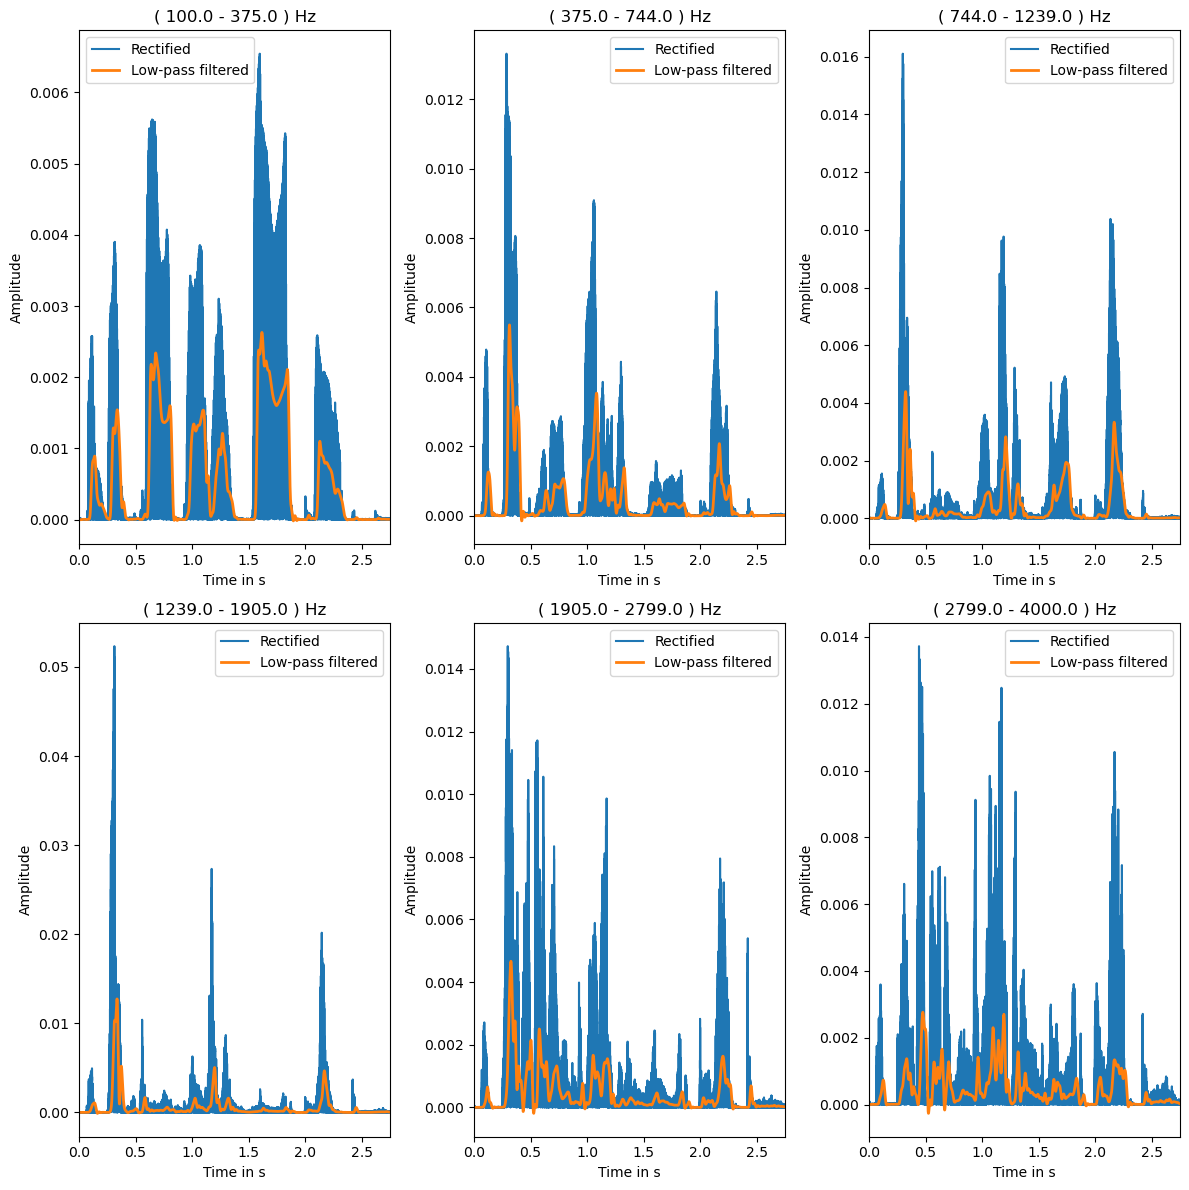

In [337]:
prototype = Butterworth(8);
responsetype = Lowpass(35; fs=Fs);
lp_filter = digitalfilter(responsetype, prototype);

# Rectifier
rect_audio = abs.(filter_output)

# Low pass filter
rect_low = zeros(N_channel,length(audio))
[rect_low[i,:] = filt(lp_filter, rect_audio[i,:]) for i = 1:N_channel]

# Compression
rect_low = atan.(rect_low)*2/pi

figure(figsize=(12,12))
for i = 1:N_channel
    subplot(2,3,i)
    plot_audio(time,rect_audio[i,:])
    plot(time,rect_low[i,:],lw=2)
    legend(["Rectified", "Low-pass filtered"])
    title(string("( ",hz_points[i]," - ",hz_points[i+1]," ) Hz"))
end
tight_layout()

In [338]:
N_signal = length(audio)
N_total = N_signal
N_period = convert.( Int, round.( Fs ./ 833 ) )
N_pulse = convert(Int, round(1e-4 * Fs))
N_offset =  convert.( Int, round( (N_period-N_pulse)/N_channel ) )

electrodes = zeros(N_channel,N_signal)

[ electrodes[i,:] = rect_low[i,:].*biphasic_pulse(N_total,N_pulse,N_period, offset = N_offset*(i-1)) for i = 1:N_channel ];

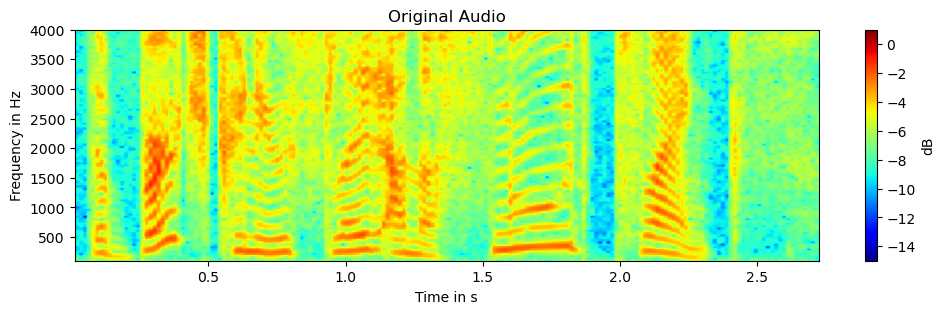

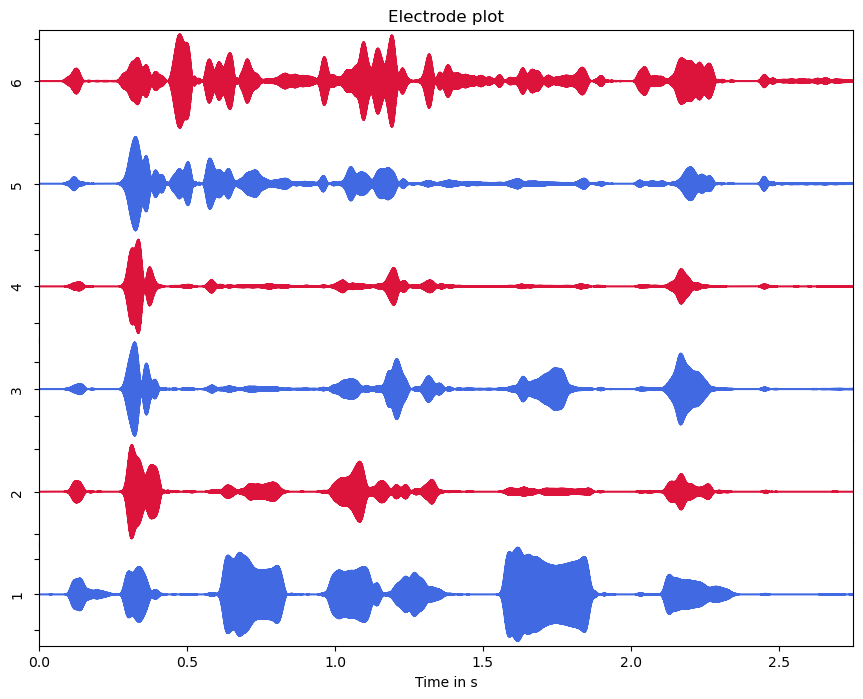

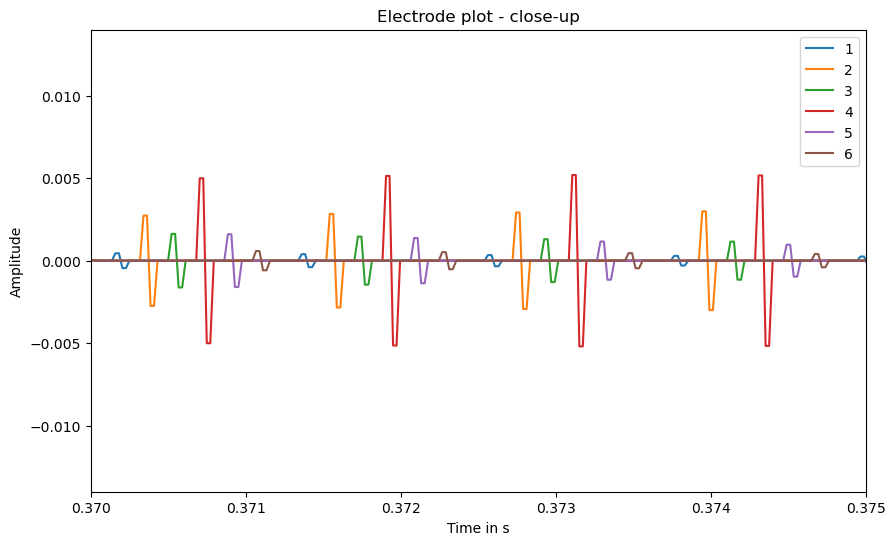

In [339]:
figure(figsize=(12,3))
plot_spectrogram(audio, Fs)
ylim([100,4000])
title("Original Audio")

plot_electrode(N_channel,time,electrodes)

figure(figsize=(10,6))
[ plot_audio(time,electrodes[i,:]) for i = 1:N_channel ]
xlim([0.37,0.375])
legend((collect(1:6)))
title("Electrode plot - close-up");

<hr style="border:2px solid black"> </hr>

### Spektral PEAK

![title](img/SPEAK.png)

In [340]:
N_channel = 20
low_freq_mel = (2595 * log10(1 + (250) / 700))  # Convert Hz to Mel
high_freq_mel = (2595 * log10(1 + (10_000) / 700))  # Convert Hz to Mel
mel_points = range(low_freq_mel, high_freq_mel, length = N_channel + 1)  # Equally spaced in Mel scale
hz_points = round.( (700 .* (10 .^(mel_points ./ 2595) .- 1)) ); # Convert Mel to Hz

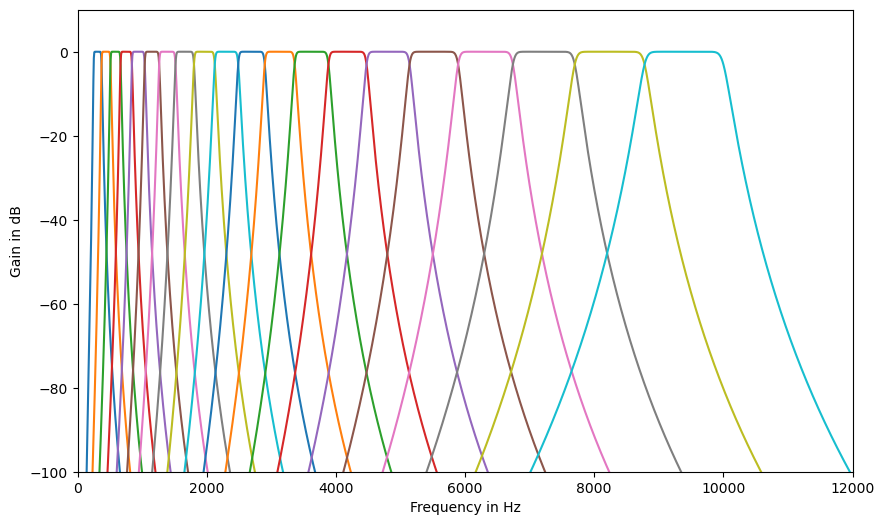

In [341]:
filter_output = zeros(N_channel,length(audio))
ω = 0:0.001:pi 

legend_str = Array{Union{Nothing, String}}(nothing, N_channel)
figure(figsize=(10,6))
for i in 1:N_channel
    responsetype = Bandpass(hz_points[i], hz_points[i+1]; fs=Fs);
    prototype = Butterworth(8);
    cochlear_filter = digitalfilter(responsetype, prototype);
    
    H = freqz(cochlear_filter, ω)
    plot(Fs/2*ω/pi, 20*log10.(abs.(H)))
    xlim([0,12e3])
    ylim([-100,10])
    xlabel("Frequency in Hz")
    ylabel("Gain in dB")
    filter_output[i,:] = filt(cochlear_filter, audio);
    #legend_str[i] = string("H",i,": ","( ",hz_points[i]," - ",hz_points[i+1]," ) Hz")
end
#legend(legend_str);

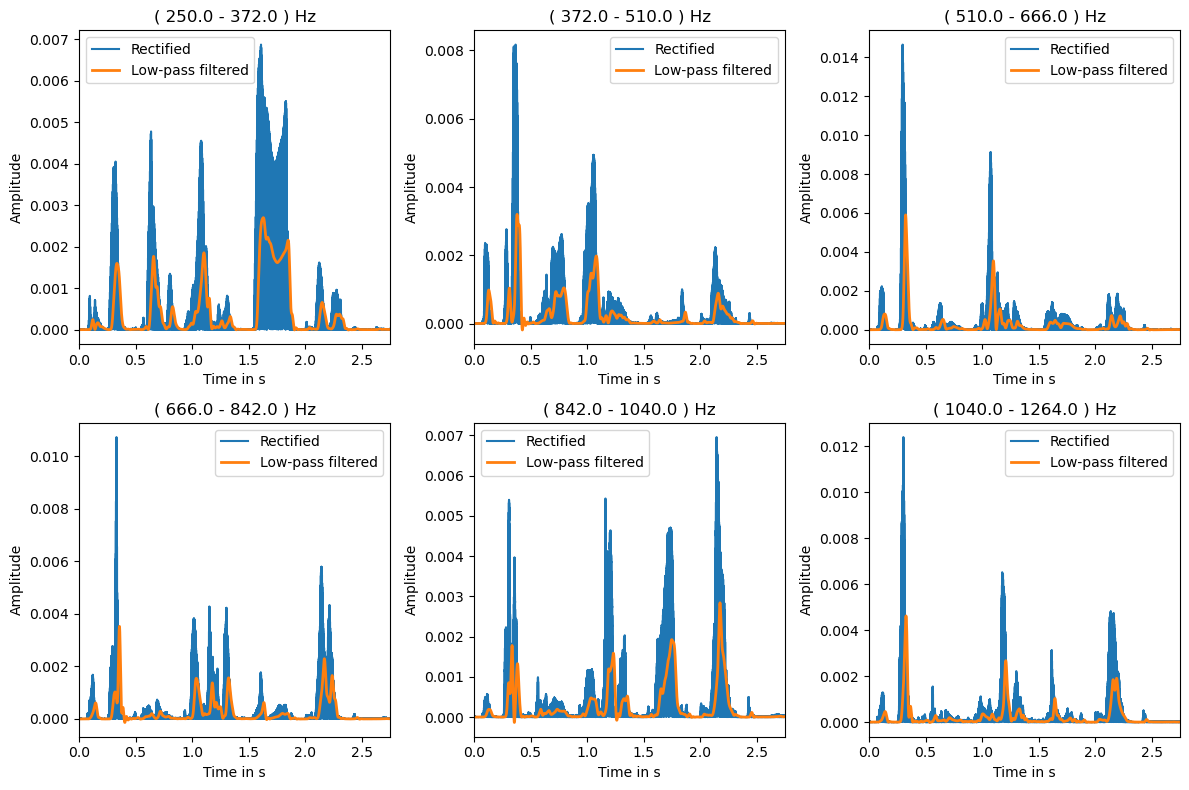

In [342]:
prototype = Butterworth(8);
responsetype = Lowpass(35; fs=Fs);
lp_filter = digitalfilter(responsetype, prototype);

# Rectifier
rect_audio = abs.(filter_output)

# Low pass filter
rect_low = zeros(N_channel,length(audio))
[rect_low[i,:] = filt(lp_filter, rect_audio[i,:]) for i = 1:N_channel]

# Compression
rect_low = atan.(rect_low)*2/pi

figure(figsize=(12,8))
for i = 1:6
    subplot(2,3,i)
    plot_audio(time,rect_audio[i,:])
    plot(time,rect_low[i,:],lw=2)
    legend(["Rectified", "Low-pass filtered"])
    title(string("( ",hz_points[i]," - ",hz_points[i+1]," ) Hz"))
end
tight_layout()

In [343]:
responsetype = Lowpass(270; fs=Fs);
cochlear_filter = digitalfilter(responsetype, prototype);
H_low = freqz(cochlear_filter, ω)
filter_output_lowpass = filt(cochlear_filter, audio);

signal_frames_F0 = generate_frames(filter_output_lowpass,Fs);

frame_length = size(signal_frames_F0)[2]
number_frames = size(signal_frames_F0)[1]
time_frames = collect( range(0,last(time),length=number_frames) )

F0_ZC = zeros((number_frames,1))

for (idx,i) in enumerate(1:number_frames)
    F0_ZC[idx] = freq_est_ZC(signal_frames_F0[i,:],Fs)
end

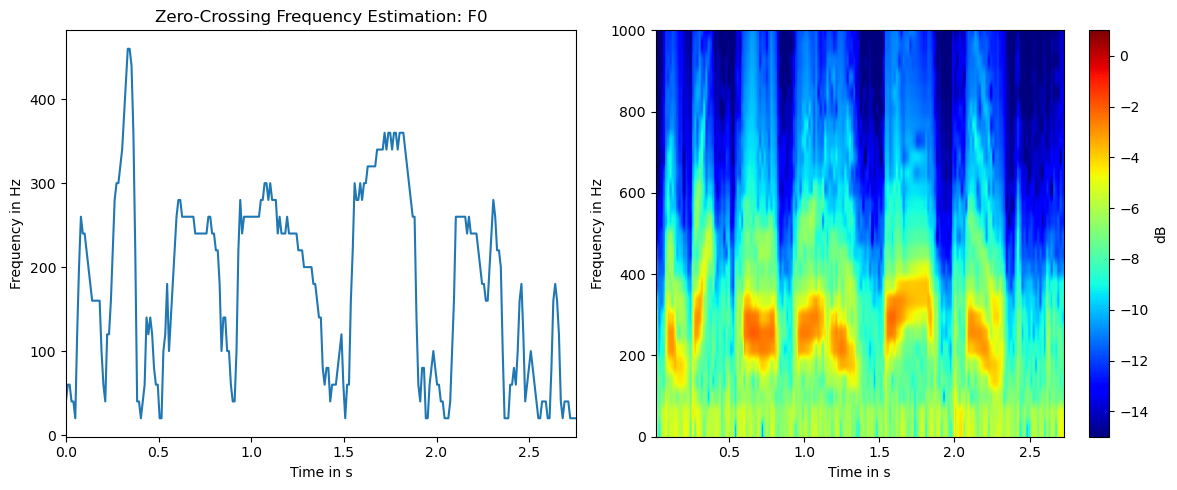

In [344]:
figure(figsize=(12,5))
subplot(1,2,1)
plot_audio(time_frames,F0_ZC)
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation: F0")
subplot(1,2,2)
plot_spectrogram(filter_output_lowpass, Fs)
ylim([0,1000])
tight_layout()

In [345]:
N_signal = length(audio)
N_total = convert(Int,ceil(N_signal/number_frames))
N_period_vec = convert.( Int, round.( Fs ./ F0_ZC ) )
N_pulse = convert(Int, 4)
N_offset_vec =  convert.( Int, round.( (N_period_vec .- N_pulse) ./ N_channel ) )
N_electrodes = 8;

In [346]:
pulses = []
electrodes = []
frame_power = zeros(N_channel,1)
idx_electrodes = zeros(N_electrodes,1)
electrode_signal = zeros(N_channel,N_signal)

for idx_frame in 1:number_frames
        
    idx_begin = (idx_frame-1)*N_total+1 
    idx_end = min(N_signal,idx_begin+N_total-1)
    idx_diff = idx_end-idx_begin
    
    for i = 1:N_channel
        frame_power[i] = sum(abs.(rect_audio[i,idx_begin : idx_end]).^2)
    end
    
    idx_electrodes = sortperm(frame_power[:],rev=true)
    idx_electrodes = idx_electrodes[1:N_electrodes]
    
    N_period = N_period_vec[idx_frame]
    N_offset = N_offset_vec[idx_frame]
    
    for i in idx_electrodes
        
        pulse_frame = biphasic_pulse(N_total,N_pulse,N_period,offset=N_offset*(i-1))
        pulse_frame = pulse_frame[1:idx_diff+1]
        
        electrode_signal[i,idx_begin : idx_end] = rect_audio[i,idx_begin : idx_end].*pulse_frame
        
    end

end

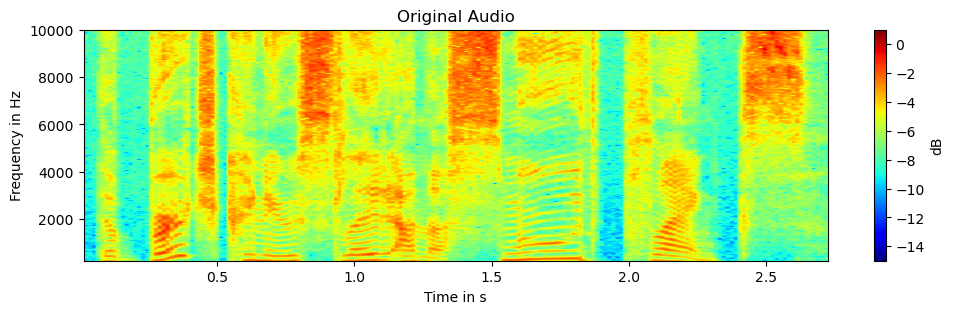

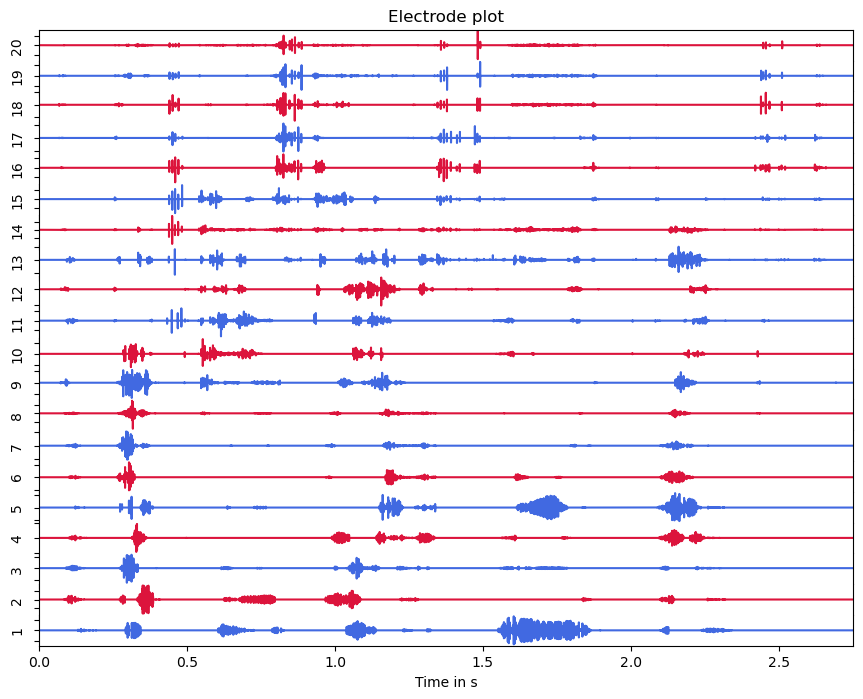

In [347]:
figure(figsize=(12,3))
plot_spectrogram(audio, Fs)
ylim([250,10_000])
title("Original Audio")

plot_electrode(N_channel,time,electrode_signal)

<hr style="border:2px solid black"> </hr>

### Advanced Combination Encoder – ACE

![title](img/SPEAK.png)

In [348]:
N_channel = 22
low_freq_mel = (2595 * log10(1 + (250) / 700))  # Convert Hz to Mel
high_freq_mel = (2595 * log10(1 + (10_000) / 700))  # Convert Hz to Mel
mel_points = range(low_freq_mel, high_freq_mel, length = N_channel + 1)  # Equally spaced in Mel scale
hz_points = round.( (700 .* (10 .^(mel_points ./ 2595) .- 1)) ); # Convert Mel to Hz

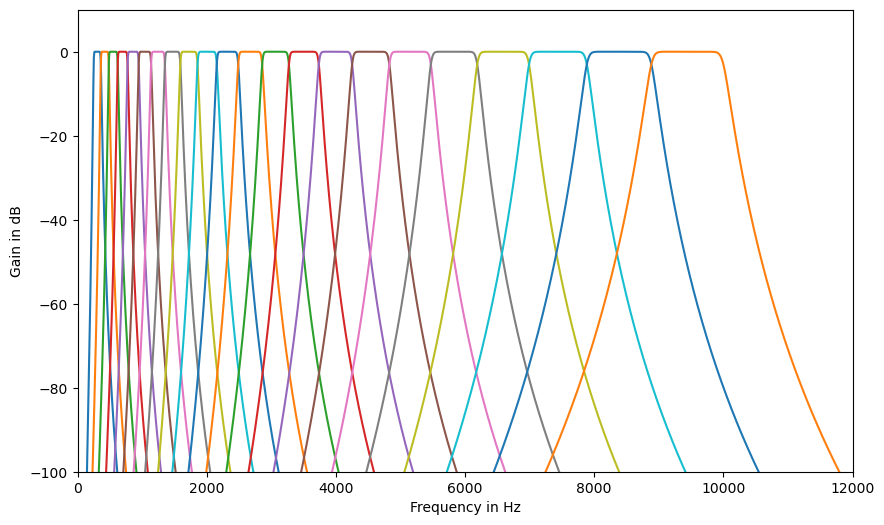

In [349]:
filter_output = zeros(N_channel,length(audio))
ω = 0:0.001:pi 

legend_str = Array{Union{Nothing, String}}(nothing, N_channel)
figure(figsize=(10,6))
for i in 1:N_channel
    responsetype = Bandpass(hz_points[i], hz_points[i+1]; fs=Fs);
    prototype = Butterworth(8);
    cochlear_filter = digitalfilter(responsetype, prototype);
    
    H = freqz(cochlear_filter, ω)
    plot(Fs/2*ω/pi, 20*log10.(abs.(H)))
    xlim([0,12e3])
    ylim([-100,10])
    xlabel("Frequency in Hz")
    ylabel("Gain in dB")
    filter_output[i,:] = filt(cochlear_filter, audio);
    #legend_str[i] = string("H",i,": ","( ",hz_points[i]," - ",hz_points[i+1]," ) Hz")
end
#legend(legend_str);

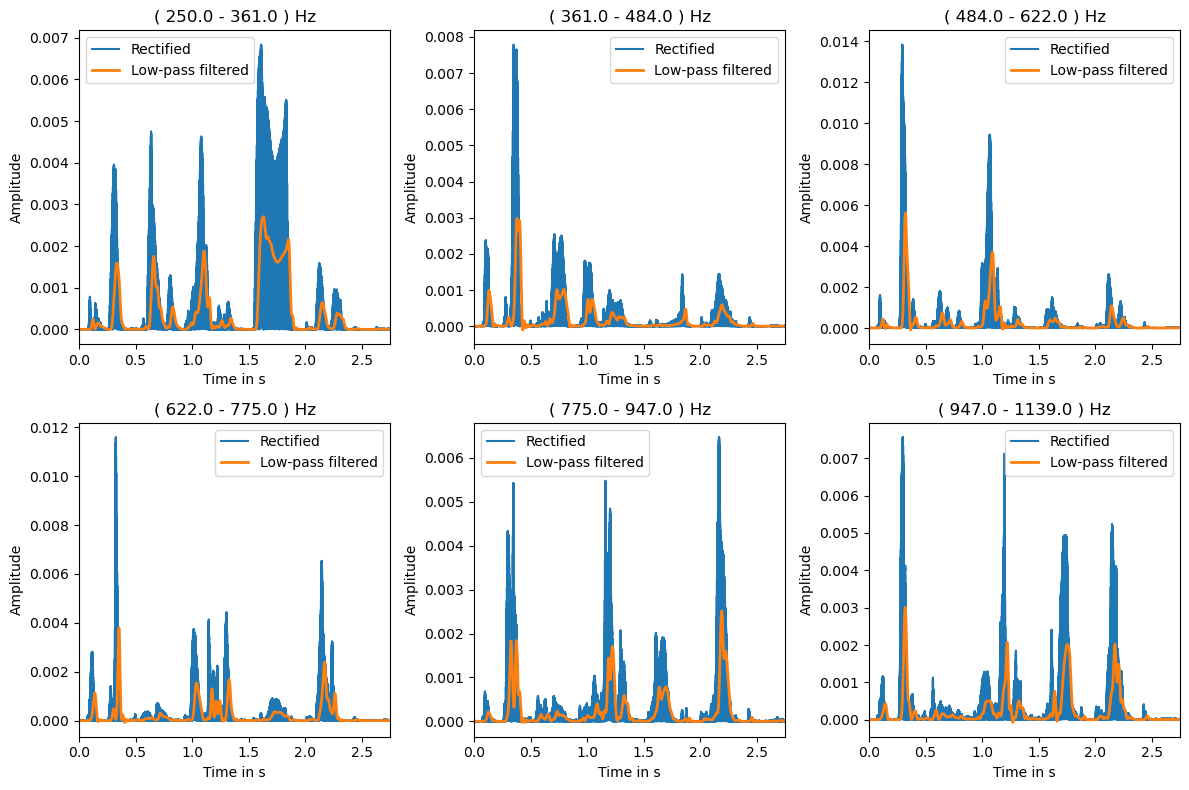

In [350]:
prototype = Butterworth(8);
responsetype = Lowpass(35; fs=Fs);
lp_filter = digitalfilter(responsetype, prototype);

# Rectifier
rect_audio = abs.(filter_output)

# Low pass filter
rect_low = zeros(N_channel,length(audio))
[rect_low[i,:] = filt(lp_filter, rect_audio[i,:]) for i = 1:N_channel]

# Compression
rect_low = atan.(rect_low)*2/pi

figure(figsize=(12,8))
for i = 1:6
    subplot(2,3,i)
    plot_audio(time,rect_audio[i,:])
    plot(time,rect_low[i,:],lw=2)
    legend(["Rectified", "Low-pass filtered"])
    title(string("( ",hz_points[i]," - ",hz_points[i+1]," ) Hz"))
end
tight_layout()

In [351]:
N_signal = length(audio)
N_total = convert(Int,ceil(N_signal/number_frames))
N_period = convert.( Int, round.( Fs ./ 900 ) )
N_pulse = convert(Int, 4)
N_offset =  convert.( Int, round.( (N_period .- N_pulse) ./ N_channel ) )
N_electrodes = 8;

In [352]:
pulses = []
electrodes = []
frame_power = zeros(N_channel,1)
idx_electrodes = zeros(N_electrodes,1)
electrode_signal = zeros(N_channel,N_signal)

for idx_frame in 1:number_frames
        
    idx_begin = (idx_frame-1)*N_total+1 
    idx_end = min(N_signal,idx_begin+N_total-1)
    idx_diff = idx_end-idx_begin
    
    for i = 1:N_channel
        frame_power[i] = sum(abs.(rect_audio[i,idx_begin : idx_end]).^2)
    end
    
    idx_electrodes = sortperm(frame_power[:],rev=true)
    idx_electrodes = idx_electrodes[1:N_electrodes]
        
    for i in idx_electrodes
        
        pulse_frame = biphasic_pulse(N_total,N_pulse,N_period,offset=N_offset*(i-1))
        pulse_frame = pulse_frame[1:idx_diff+1]
        
        electrode_signal[i,idx_begin : idx_end] = rect_audio[i,idx_begin : idx_end].*pulse_frame
        
    end

end

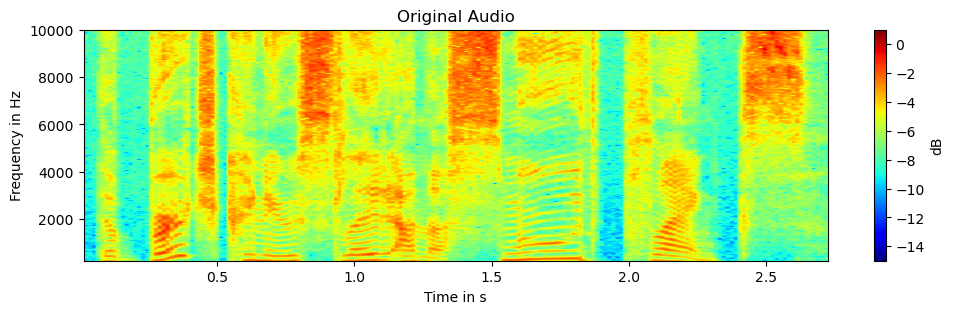

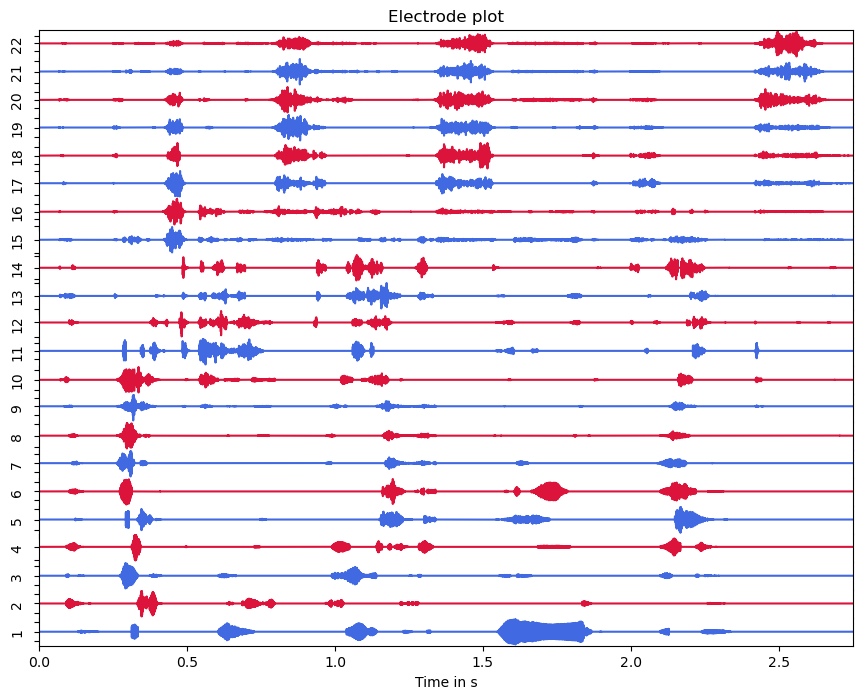

In [353]:
figure(figsize=(12,3))
plot_spectrogram(audio, Fs)
ylim([250,10_000])
title("Original Audio")

plot_electrode(N_channel,time,electrode_signal)

<hr style="border:2px solid black"> </hr>

### Fine Structure Processing – CSSS

![title](img/FSP.png)

In [386]:
N_channel = 12
low_freq_mel = (2595 * log10(1 + (50) / 700))  # Convert Hz to Mel
high_freq_mel = (2595 * log10(1 + (10_000) / 700))  # Convert Hz to Mel
mel_points = range(low_freq_mel, high_freq_mel, length = N_channel + 1)  # Equally spaced in Mel scale
hz_points = round.( (700 .* (10 .^(mel_points ./ 2595) .- 1)) ) # Convert Mel to Hz

13-element Vector{Float64}:
    50.0
   236.0
   468.0
   758.0
  1119.0
  1570.0
  2133.0
  2835.0
  3712.0
  4806.0
  6171.0
  7874.0
 10000.0

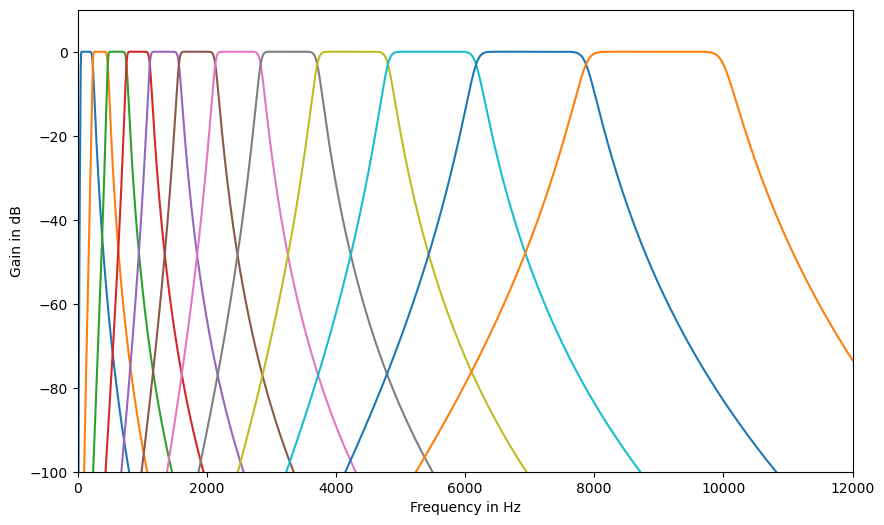

In [387]:
filter_output = zeros(N_channel,length(audio))
ω = 0:0.001:pi 

legend_str = Array{Union{Nothing, String}}(nothing, N_channel)
figure(figsize=(10,6))
for i in 1:N_channel
    responsetype = Bandpass(hz_points[i], hz_points[i+1]; fs=Fs);
    prototype = Butterworth(8);
    cochlear_filter = digitalfilter(responsetype, prototype);
    
    H = freqz(cochlear_filter, ω)
    plot(Fs/2*ω/pi, 20*log10.(abs.(H)))
    xlim([0,12e3])
    ylim([-100,10])
    xlabel("Frequency in Hz")
    ylabel("Gain in dB")
    filter_output[i,:] = filt(cochlear_filter, audio);
    #legend_str[i] = string("H",i,": ","( ",hz_points[i]," - ",hz_points[i+1]," ) Hz")
end
#legend(legend_str);

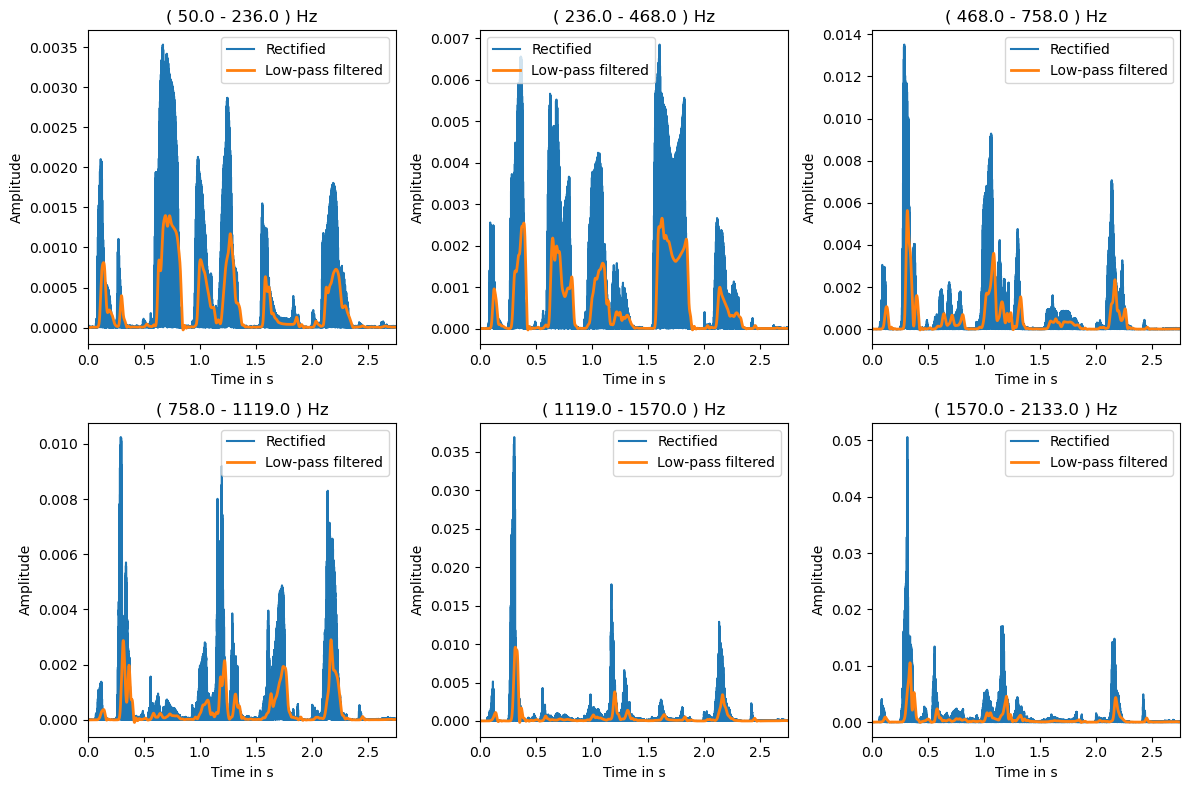

In [388]:
prototype = Butterworth(8);
responsetype = Lowpass(35; fs=Fs);
lp_filter = digitalfilter(responsetype, prototype);

# Rectifier
rect_audio = abs.(filter_output)

# Low pass filter
rect_low = zeros(N_channel,length(audio))
[rect_low[i,:] = filt(lp_filter, rect_audio[i,:]) for i = 1:N_channel]

# Compression
rect_low = atan.(rect_low)*2/pi

figure(figsize=(12,8))
for i = 1:6
    subplot(2,3,i)
    plot_audio(time,rect_audio[i,:])
    plot(time,rect_low[i,:],lw=2)
    legend(["Rectified", "Low-pass filtered"])
    title(string("( ",hz_points[i]," - ",hz_points[i+1]," ) Hz"))
end
tight_layout()

In [391]:
temp = generate_frames(filter_output[1,:],Fs);
frame_length = size(temp)[2]
number_frames = size(temp)[1]
time_frames = collect( range(0,last(time),length=number_frames) )

N_FSP = length(hz_points[hz_points .< 1000])
signal_frames = zeros(N_FSP,number_frames,frame_length);

for i = 1:N_FSP
    signal_frames[i,:,:] = generate_frames(filter_output[i,:],Fs);
end

In [396]:
F_ZC = zeros((N_FSP,number_frames))

for idx_channel = 1:N_FSP
    for idx = 1:number_frames
        F_ZC[idx_channel,idx] = freq_est_ZC(signal_frames[idx_channel,idx,:],Fs);
    end
end
maximum(F_ZC)

1140.5172413793102

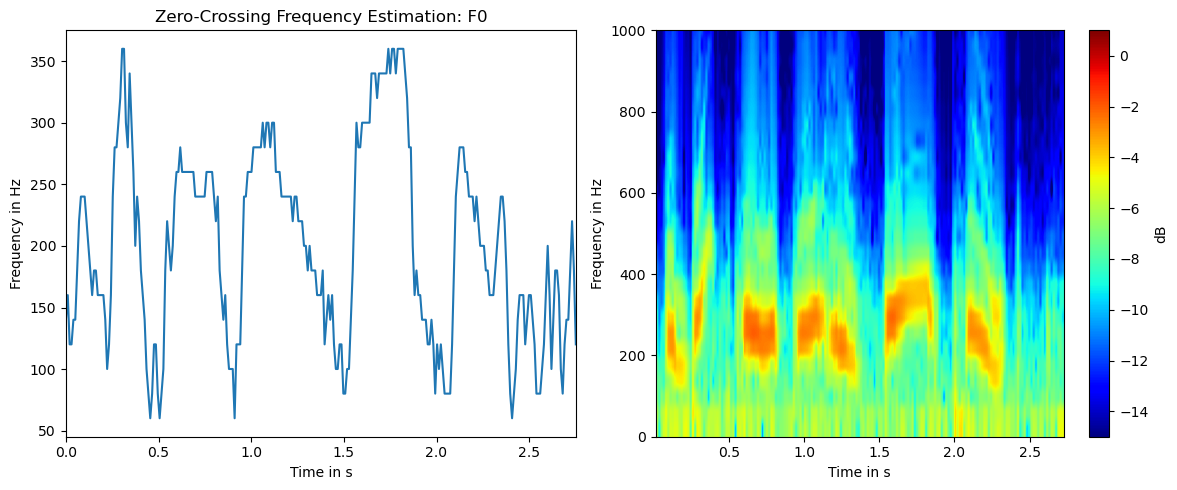

In [393]:
figure(figsize=(12,5))
subplot(1,2,1)
plot_audio(time_frames,F_ZC[1,:])
ylabel("Frequency in Hz")
title("Zero-Crossing Frequency Estimation: F0")
subplot(1,2,2)
plot_spectrogram(filter_output_lowpass, Fs)
ylim([0,1000])
tight_layout()

In [433]:
N_signal = length(audio)
N_total = convert(Int,ceil(N_signal/number_frames))

N_period_vec = convert.( Int, round.( Fs ./ F_ZC ) )
N_pulse = convert(Int, 4)

N_period_max = convert.( Int, round.( Fs ./ 1500 ) )
N_offset =  convert.( Int, round.( (N_period_max .- N_pulse) ./ N_channel ) )
N_electrodes = 8;

In [434]:
pulses = []
electrodes = []
frame_power = zeros(N_channel,1)
idx_electrodes = zeros(N_electrodes,1)
electrode_signal = zeros(N_channel,N_signal)

for idx_frame in 1:number_frames
        
    idx_begin = (idx_frame-1)*N_total+1 
    idx_end = min(N_signal,idx_begin+N_total-1)
    idx_diff = idx_end-idx_begin
    
    for i = 1:N_channel
        frame_power[i] = sum(abs.(rect_audio[i,idx_begin : idx_end]).^2)
    end
    
    idx_electrodes = sortperm(frame_power[:],rev=true)
    idx_electrodes = idx_electrodes[1:N_electrodes]
    
    for i in idx_electrodes
        
        if i <= N_FSP
            N_period = N_period_vec[i,idx_frame]
        else 
            N_period = convert.( Int, round.( Fs ./ 1500 ) )
        end
        
        pulse_frame = biphasic_pulse(N_total,N_pulse,N_period,offset=N_offset*(i-1))
        pulse_frame = pulse_frame[1:idx_diff+1]  
        electrode_signal[i,idx_begin : idx_end] = rect_audio[i,idx_begin : idx_end].*pulse_frame
        
    end

end

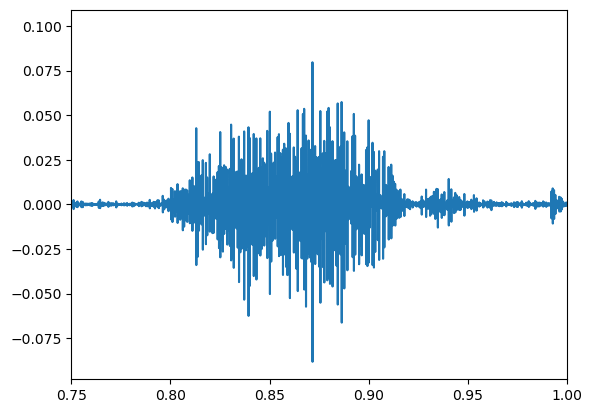

(0.75, 1.0)

In [435]:
plot(time,electrode_signal[12,:])
xlim([0.75,1])

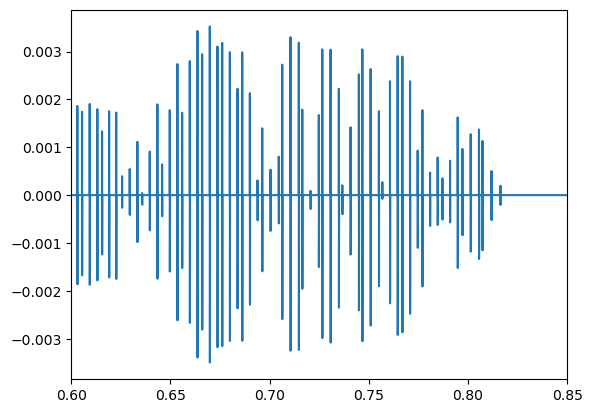

(0.6, 0.85)

In [436]:
plot(time,electrode_signal[1,:])
xlim([0.6,0.85])

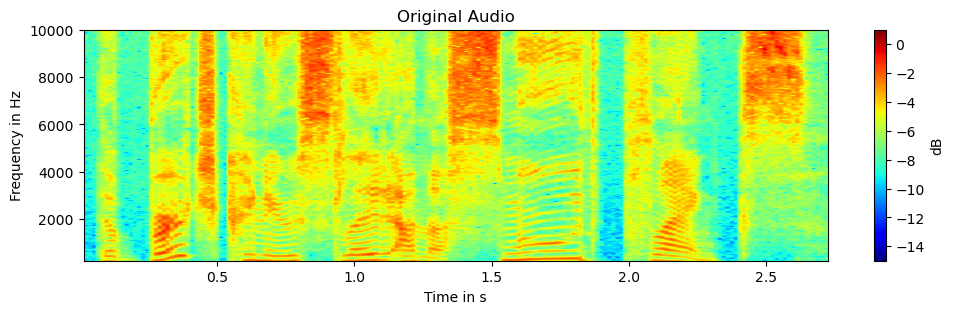

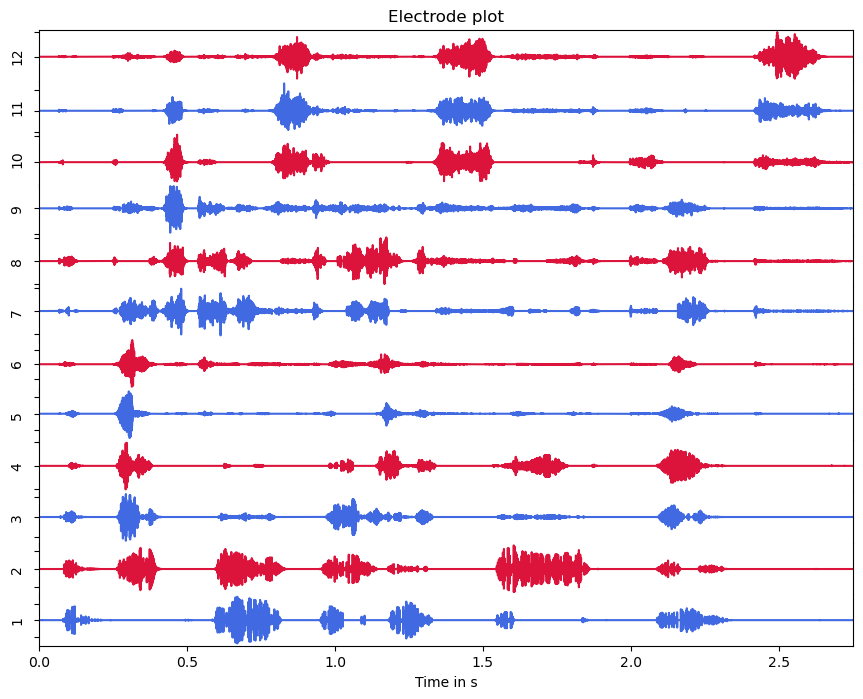

In [437]:
figure(figsize=(12,3))
plot_spectrogram(audio, Fs)
ylim([250,10_000])
title("Original Audio")

plot_electrode(N_channel,time,electrode_signal)

### Testing zero-crossing